### Check GPU

In [ ]:
!nvidia-smi

Wed Jun 19 04:08:33 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   51C    P8              18W /  72W |      4MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
tf.__version__

'2.15.0'

In [ ]:
!pip install tensorflow_addons keras_cv ipython-autotime
%load_ext autotime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 52.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 67.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 62.2 MB/s eta 0:00:00
time: 273 µs (started: 2024-06-20 12:40:09 +00:00)


In [ ]:
!pip install -q -U wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.1/296.1 kB 37.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 10.2 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### **Mount Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


### **Import libraries**

In [ ]:
import numpy as np
import matplotlib.pylab as plt
import tensorflow_addons as tfa
import keras_cv
import seaborn as sns
import os
import imghdr
import pandas as pd
import mimetypes
from PIL import Image
import wandb

from tensorflow.keras import layers
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B0, EfficientNetV2B1, EfficientNetV2B2, preprocess_input
# from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.optimizers.experimental import AdamW
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau
# from tensorflow.keras.losses import SparseCategoricalCrossentropy
# from tensorflow.keras.metrics import SparseCategoricalAccuracy
from sklearn.metrics import confusion_matrix

# from wandb.integration.keras import WandbCallback, WandbMetricsLogger, WandbModelCheckpoint
# from wandb.integration.ultralytics import add_wandb_callback

SEED_VALUE = 888888

### **Log in to Wandb**
This will be used for model and experiment tracking

In [ ]:
# Log in to your W&B account
wandb.login(key='441533e8d091865060ff9d7989639f2207b0db32')

wandb: Currently logged in as: cpedrosa. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

### **Initialize tunable hyperparameters**

In [ ]:
EPOCHS = 150
BATCH_SIZE = 32
IMG_SIZE = 224
DROPOUT = 0.3

#Optimizer HPs (Adabeleif):
INIT_LEARNING_RATE = [0.0001, 0.00001]
TL_EPSILON = 1e-11
TL_WEIGHT_DECAY = 1e-2
OPTIMIZER = ["adabelief", 'adam']

### **Load the data and assign the train, val, and test sets**

*Used the image_dataset_from directory to create the 70-10-20 train-val-test split.*

In [ ]:
data_loc = '/content/drive/My Drive/Colab Notebooks/Data/car-damage-dataset/data2a/combined'

# Step 1: Split data into 70% training and 30% for validation+test
train_set_raw = tf.keras.utils.image_dataset_from_directory(
    directory=data_loc,
    validation_split=0.3,  # 30% of data will be set aside for validation+test
    subset="training",     # 70% of data for training
    seed=SEED_VALUE,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    shuffle=True
)

val_test_set_raw = tf.keras.utils.image_dataset_from_directory(
    directory=data_loc,
    validation_split=0.3,
    subset="validation",   # 30% of data for validation+test
    seed=SEED_VALUE,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    shuffle=True
)

# Step 2: Split the 30% validation+test set into 10% validation and 20% test
val_test_batches = tf.data.experimental.cardinality(val_test_set_raw).numpy()

test_size = int(val_test_batches * (2/3))  # 20% of total dataset
val_size = val_test_batches - test_size    # Remaining 10% of total dataset

test_set_raw = val_test_set_raw.take(test_size)
val_set_raw = val_test_set_raw.skip(test_size).take(val_size)

Found 10329 files belonging to 3 classes.
Using 7231 files for training.
Found 10329 files belonging to 3 classes.
Using 3098 files for validation.


In [ ]:
class_names = np.array(train_set_raw.class_names)
print(class_names)

['front' 'rear' 'side']


In [ ]:
num_test_images = 0
for images, labels in train_set_raw:
    num_test_images += len(labels)
print(f"Number of test images: {num_test_images}")

Number of test images: 7231
time: 18 s (started: 2024-06-18 13:08:20 +00:00)


### **Use buffered prefetching for performance**

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_set = train_set_raw.prefetch(buffer_size=AUTOTUNE)
val_set = val_set_raw.prefetch(buffer_size=AUTOTUNE)
test_set = test_set_raw.prefetch(buffer_size=AUTOTUNE)

### Define the on-the-fly data augmentation steps

*Augmentation help address the lack of training data scarcity. Only included realistic items.*

In [ ]:
## augmentation steps
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomZoom(0.3),
  layers.RandomBrightness(factor=0.18),
  layers.RandomContrast(factor=0.4)
])

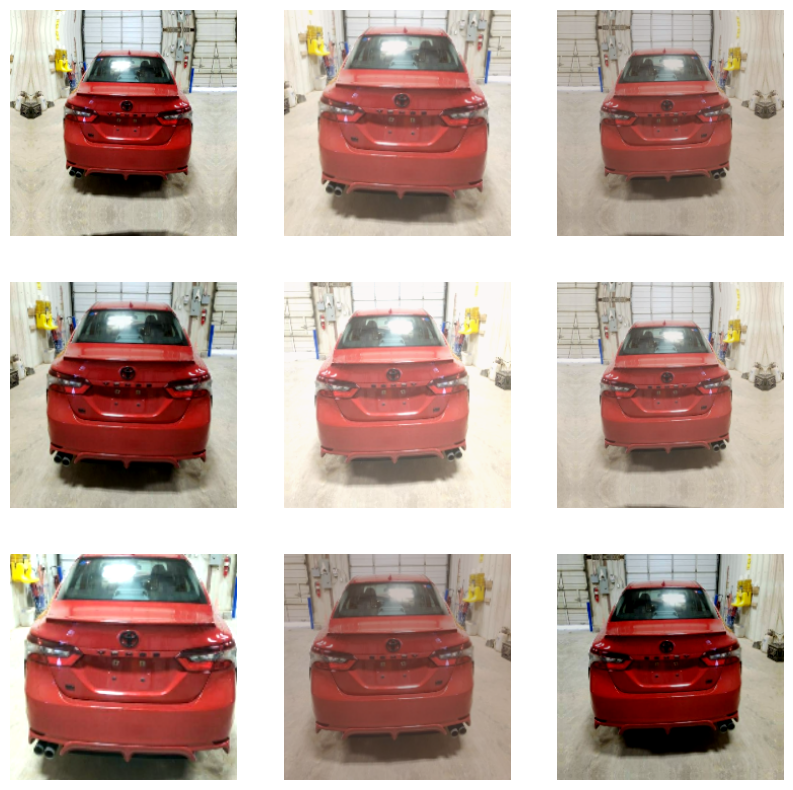

time: 1.59 s (started: 2024-06-18 13:17:42 +00:00)


In [ ]:
## visualize the augmented images
plt.figure(figsize=(10, 10))
for images, _ in train_set_raw.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### **Create the base model**

In [ ]:
base_model = EfficientNetV2B0(weights='imagenet',
                             include_top=False,
                             pooling='avg',
                             input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Freeze
base_model.trainable = False
base_model.summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_1 (Rescaling)     (None, 224, 224, 3)          0         ['input_4[0][0]']             
                                                                                                  
 normalization_1 (Normaliza  (None, 224, 224, 3)          0         ['rescaling_1[0][0]']         
 tion)                                                                                            
                                                                                                  
 stem_conv (Conv2D)          (None, 112, 112, 32)         864       ['normalizatio

### **Attach the new top layers / classification head**

*Make sure that the inputs are aligned with the preprocess_input of EfficientNetV2B0*

In [ ]:
## Define the model
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)  # Apply data augmentation
x = preprocess_input(x)  # Preprocess input
x = base_model(x, training=False)  # Use base model, setting training=False for inference mode
x = Dropout(0.3)(x)  # Apply dropout
outputs = Dense(3, activation='softmax')(x)  # Output layer

model = Model(inputs, outputs)  # Create the final model

time: 1.01 s (started: 2024-06-19 12:45:13 +00:00)


### **Compile the model**

*Use the custom AdaBelief optimizer for faster convergence and better accuracy.*

In [ ]:
optim = tfa.optimizers.AdaBelief(learning_rate=0.0001,
                                 weight_decay=TL_WEIGHT_DECAY,
                                 epsilon=TL_EPSILON)

model.compile(optimizer="Adam",
             loss="sparse_categorical_crossentropy",
             metrics=['acc'])

time: 15.4 ms (started: 2024-06-19 12:45:25 +00:00)


In [ ]:
## check model summary
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 efficientnetv2-b0 (Functio  (None, 1280)              5919312   
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 3)                 3843      
                                                                 
Total params: 5923155 (22.60 MB)
Trainable params: 3843 (15.01 KB)
Non-trainable params: 5919312 (22.58 MB)
_________________

### **Train the model**

In [ ]:
## Define a function to manually train with different hyperparameter combinations
def train(learning_rate, optimizer):

    epoch = 0  # Initialize epoch counter
    best_val_acc = 0.0
    best_val_loss = float("inf")

    ## Initialize a new wandb run
    run = wandb.init(project="experiment_tuning_panel",
                     config={"dropout": DROPOUT,
                             "epochs": EPOCHS,
                             "learning_rate": learning_rate,
                             "optimizer": optimizer,
                             "weight_decay": TL_WEIGHT_DECAY,
                             "epsilon": TL_EPSILON,
                             "batch_size": BATCH_SIZE},
                     save_code=True)

    ## Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config

    ## Define the model architecture
    base_model = MobileNetV2(weights='imagenet',
                                  include_top=False,
                                  pooling='avg',
                                  input_shape=(IMG_SIZE, IMG_SIZE, 3))

    ## Freeze the base model
    base_model.trainable = False

    inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = data_augmentation(inputs)
    x = preprocess_input(x)
    x = base_model(x, training=False)
    x = Dropout(config.dropout)(x)
    outputs = Dense(3, activation='softmax')(x)
    model = Model(inputs, outputs)

    ## Compile the model (initial training phase)
    if config.optimizer == 'adabelief':
        optimizer_instance = tfa.optimizers.AdaBelief(learning_rate=config.learning_rate, epsilon=config.epsilon,
                                                      weight_decay=config.weight_decay)
    elif config.optimizer == 'adam':
        optimizer_instance = Adam(learning_rate=config.learning_rate, epsilon=config.epsilon,
                                                  weight_decay=config.weight_decay)

    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer_instance, metrics=['acc'])
    model.summary()


    # reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.10,
    #                               patience=10)

     # Train the model (initial training phase)
    history = model.fit(
                        train_set,
                        epochs=config.epochs,
                        validation_data=val_set,
                        callbacks=[
            WandbMetricsLogger(),
            WandbModelCheckpoint("models")
        ], verbose = True
                    )

    ## Get the validation accuracy and loss from the history
    val_acc = history.history['val_acc'][-1]
    val_loss = history.history['val_loss'][-1]

    ## Update best values based on the entire training history
    best_val_acc = max(history.history['val_acc'])
    best_val_loss = min(history.history['val_loss'])

    ## Log metrics to wandb for the last epoch and the best epoch
    wandb.log({"last_epoch": epoch, "last_val_acc": val_acc, "last_val_loss": val_loss})
    wandb.log({"best_epoch": history.history['val_acc'].index(best_val_acc), "best_val_acc": best_val_acc, "best_val_loss": best_val_loss})
    # # Log metrics to wandb for the last epoch and the best epoch
    # wandb.log({
    #     "last_epoch": {"epoch": epoch, "val_acc": val_acc, "val_loss": val_loss},
    #     "best_epoch": {"epoch": history.history['val_acc'].index(best_val_acc), "val_acc": best_val_acc, "val_loss": best_val_loss}
    # })

    ## Update wandb summary with the best values
    wandb.run.summary["best_val_acc"] = best_val_acc
    wandb.run.summary["best_val_loss"] = best_val_loss

    epoch += 1


    ## Finish the run to ensure all data is logged
    run.finish()

In [ ]:
## Iterate through combinations
for optimizer in OPTIMIZER:
  for learning_rate in INIT_LEARNING_RATE:
    train(learning_rate, optimizer)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 224, 224, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 1280)              2257984   
 tional)                                                         
                                                             

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 82s 191ms/step - loss: 1.2776 - acc: 0.3648 - val_loss: 1.0182 - val_acc: 0.5038
Epoch 2/150
226/226 [==============================] - ETA: 0s - loss: 0.9799 - acc: 0.5457

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 187ms/step - loss: 0.9799 - acc: 0.5457 - val_loss: 0.7849 - val_acc: 0.6914
Epoch 3/150
226/226 [==============================] - ETA: 0s - loss: 0.7782 - acc: 0.6716

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.7782 - acc: 0.6716 - val_loss: 0.6337 - val_acc: 0.7867
Epoch 4/150
226/226 [==============================] - ETA: 0s - loss: 0.6521 - acc: 0.7451

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.6521 - acc: 0.7451 - val_loss: 0.5551 - val_acc: 0.8229
Epoch 5/150
226/226 [==============================] - ETA: 0s - loss: 0.5729 - acc: 0.7816

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.5729 - acc: 0.7816 - val_loss: 0.4954 - val_acc: 0.8371
Epoch 6/150
226/226 [==============================] - ETA: 0s - loss: 0.5274 - acc: 0.8050

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 187ms/step - loss: 0.5274 - acc: 0.8050 - val_loss: 0.4565 - val_acc: 0.8486
Epoch 7/150
226/226 [==============================] - ETA: 0s - loss: 0.4955 - acc: 0.8187

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 187ms/step - loss: 0.4955 - acc: 0.8187 - val_loss: 0.4273 - val_acc: 0.8552
Epoch 8/150
226/226 [==============================] - ETA: 0s - loss: 0.4739 - acc: 0.8248

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 188ms/step - loss: 0.4739 - acc: 0.8248 - val_loss: 0.4155 - val_acc: 0.8581
Epoch 9/150
226/226 [==============================] - ETA: 0s - loss: 0.4519 - acc: 0.8311

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 188ms/step - loss: 0.4519 - acc: 0.8311 - val_loss: 0.3899 - val_acc: 0.8705
Epoch 10/150
226/226 [==============================] - ETA: 0s - loss: 0.4313 - acc: 0.8415

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 188ms/step - loss: 0.4313 - acc: 0.8415 - val_loss: 0.3849 - val_acc: 0.8705
Epoch 11/150
226/226 [==============================] - ETA: 0s - loss: 0.4199 - acc: 0.8446

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 188ms/step - loss: 0.4199 - acc: 0.8446 - val_loss: 0.3644 - val_acc: 0.8752
Epoch 12/150
226/226 [==============================] - ETA: 0s - loss: 0.4133 - acc: 0.8435

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.4133 - acc: 0.8435 - val_loss: 0.3616 - val_acc: 0.8705
Epoch 13/150
226/226 [==============================] - ETA: 0s - loss: 0.4028 - acc: 0.8504

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 187ms/step - loss: 0.4028 - acc: 0.8504 - val_loss: 0.3470 - val_acc: 0.8771
Epoch 14/150
226/226 [==============================] - ETA: 0s - loss: 0.3937 - acc: 0.8537

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.3937 - acc: 0.8537 - val_loss: 0.3363 - val_acc: 0.8781
Epoch 15/150
226/226 [==============================] - ETA: 0s - loss: 0.3843 - acc: 0.8553

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.3843 - acc: 0.8553 - val_loss: 0.3549 - val_acc: 0.8705
Epoch 16/150
226/226 [==============================] - ETA: 0s - loss: 0.3762 - acc: 0.8570

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.3762 - acc: 0.8570 - val_loss: 0.3430 - val_acc: 0.8733
Epoch 17/150
226/226 [==============================] - ETA: 0s - loss: 0.3738 - acc: 0.8613

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 187ms/step - loss: 0.3738 - acc: 0.8613 - val_loss: 0.3378 - val_acc: 0.8771
Epoch 18/150
226/226 [==============================] - ETA: 0s - loss: 0.3730 - acc: 0.8609

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.3730 - acc: 0.8609 - val_loss: 0.3301 - val_acc: 0.8800
Epoch 19/150
226/226 [==============================] - ETA: 0s - loss: 0.3637 - acc: 0.8654

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 184ms/step - loss: 0.3637 - acc: 0.8654 - val_loss: 0.3150 - val_acc: 0.8857
Epoch 20/150
226/226 [==============================] - ETA: 0s - loss: 0.3584 - acc: 0.8628

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.3584 - acc: 0.8628 - val_loss: 0.3145 - val_acc: 0.8905
Epoch 21/150
226/226 [==============================] - ETA: 0s - loss: 0.3520 - acc: 0.8663

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 187ms/step - loss: 0.3520 - acc: 0.8663 - val_loss: 0.3119 - val_acc: 0.8943
Epoch 22/150
226/226 [==============================] - ETA: 0s - loss: 0.3564 - acc: 0.8678

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.3564 - acc: 0.8678 - val_loss: 0.2989 - val_acc: 0.8971
Epoch 23/150
226/226 [==============================] - ETA: 0s - loss: 0.3481 - acc: 0.8721

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 187ms/step - loss: 0.3481 - acc: 0.8721 - val_loss: 0.2998 - val_acc: 0.8905
Epoch 24/150
226/226 [==============================] - ETA: 0s - loss: 0.3385 - acc: 0.8722

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.3385 - acc: 0.8722 - val_loss: 0.3014 - val_acc: 0.8924
Epoch 25/150
226/226 [==============================] - ETA: 0s - loss: 0.3421 - acc: 0.8732

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.3421 - acc: 0.8732 - val_loss: 0.3145 - val_acc: 0.8867
Epoch 26/150
226/226 [==============================] - ETA: 0s - loss: 0.3371 - acc: 0.8743

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 183ms/step - loss: 0.3371 - acc: 0.8743 - val_loss: 0.3116 - val_acc: 0.8867
Epoch 27/150
226/226 [==============================] - ETA: 0s - loss: 0.3436 - acc: 0.8700

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.3436 - acc: 0.8700 - val_loss: 0.3078 - val_acc: 0.8924
Epoch 28/150
226/226 [==============================] - ETA: 0s - loss: 0.3391 - acc: 0.8764

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 184ms/step - loss: 0.3391 - acc: 0.8764 - val_loss: 0.2939 - val_acc: 0.8962
Epoch 29/150
226/226 [==============================] - ETA: 0s - loss: 0.3417 - acc: 0.8677

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 184ms/step - loss: 0.3417 - acc: 0.8677 - val_loss: 0.2976 - val_acc: 0.8924
Epoch 30/150
226/226 [==============================] - ETA: 0s - loss: 0.3281 - acc: 0.8751

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 183ms/step - loss: 0.3281 - acc: 0.8751 - val_loss: 0.2940 - val_acc: 0.8971
Epoch 31/150
226/226 [==============================] - ETA: 0s - loss: 0.3315 - acc: 0.8747

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 184ms/step - loss: 0.3315 - acc: 0.8747 - val_loss: 0.2959 - val_acc: 0.8971
Epoch 32/150
226/226 [==============================] - ETA: 0s - loss: 0.3313 - acc: 0.8706

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.3313 - acc: 0.8706 - val_loss: 0.3011 - val_acc: 0.8914
Epoch 33/150
226/226 [==============================] - ETA: 0s - loss: 0.3267 - acc: 0.8748

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.3267 - acc: 0.8748 - val_loss: 0.2852 - val_acc: 0.8981
Epoch 34/150
226/226 [==============================] - ETA: 0s - loss: 0.3248 - acc: 0.8773

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 183ms/step - loss: 0.3248 - acc: 0.8773 - val_loss: 0.2948 - val_acc: 0.8905
Epoch 35/150
226/226 [==============================] - ETA: 0s - loss: 0.3134 - acc: 0.8830

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.3134 - acc: 0.8830 - val_loss: 0.2937 - val_acc: 0.8905
Epoch 36/150
226/226 [==============================] - ETA: 0s - loss: 0.3271 - acc: 0.8765

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.3271 - acc: 0.8765 - val_loss: 0.2966 - val_acc: 0.8924
Epoch 37/150
226/226 [==============================] - ETA: 0s - loss: 0.3169 - acc: 0.8802

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 184ms/step - loss: 0.3169 - acc: 0.8802 - val_loss: 0.2873 - val_acc: 0.9000
Epoch 38/150
226/226 [==============================] - ETA: 0s - loss: 0.3180 - acc: 0.8838

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.3180 - acc: 0.8838 - val_loss: 0.2924 - val_acc: 0.9000
Epoch 39/150
226/226 [==============================] - ETA: 0s - loss: 0.3272 - acc: 0.8787

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 184ms/step - loss: 0.3272 - acc: 0.8787 - val_loss: 0.2876 - val_acc: 0.9038
Epoch 40/150
226/226 [==============================] - ETA: 0s - loss: 0.3129 - acc: 0.8805

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 184ms/step - loss: 0.3129 - acc: 0.8805 - val_loss: 0.2958 - val_acc: 0.8924
Epoch 41/150
226/226 [==============================] - ETA: 0s - loss: 0.3210 - acc: 0.8852

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.3210 - acc: 0.8852 - val_loss: 0.2769 - val_acc: 0.9019
Epoch 42/150
226/226 [==============================] - ETA: 0s - loss: 0.3207 - acc: 0.8802

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.3207 - acc: 0.8802 - val_loss: 0.2817 - val_acc: 0.9038
Epoch 43/150
226/226 [==============================] - ETA: 0s - loss: 0.3189 - acc: 0.8822

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.3189 - acc: 0.8822 - val_loss: 0.2826 - val_acc: 0.9019
Epoch 44/150
226/226 [==============================] - ETA: 0s - loss: 0.3188 - acc: 0.8823

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.3188 - acc: 0.8823 - val_loss: 0.2888 - val_acc: 0.8990
Epoch 45/150
226/226 [==============================] - ETA: 0s - loss: 0.3083 - acc: 0.8818

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.3083 - acc: 0.8818 - val_loss: 0.2932 - val_acc: 0.8914
Epoch 46/150
226/226 [==============================] - ETA: 0s - loss: 0.3144 - acc: 0.8822

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 187ms/step - loss: 0.3144 - acc: 0.8822 - val_loss: 0.2810 - val_acc: 0.9000
Epoch 47/150
226/226 [==============================] - ETA: 0s - loss: 0.3096 - acc: 0.8848

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.3096 - acc: 0.8848 - val_loss: 0.2764 - val_acc: 0.9019
Epoch 48/150
226/226 [==============================] - ETA: 0s - loss: 0.3126 - acc: 0.8845

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.3126 - acc: 0.8845 - val_loss: 0.2851 - val_acc: 0.9010
Epoch 49/150
226/226 [==============================] - ETA: 0s - loss: 0.3023 - acc: 0.8899

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.3023 - acc: 0.8899 - val_loss: 0.2670 - val_acc: 0.9076
Epoch 50/150
226/226 [==============================] - ETA: 0s - loss: 0.3059 - acc: 0.8838

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 187ms/step - loss: 0.3059 - acc: 0.8838 - val_loss: 0.2874 - val_acc: 0.9000
Epoch 51/150
226/226 [==============================] - ETA: 0s - loss: 0.3123 - acc: 0.8855

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 183ms/step - loss: 0.3123 - acc: 0.8855 - val_loss: 0.2871 - val_acc: 0.8990
Epoch 52/150
226/226 [==============================] - ETA: 0s - loss: 0.3069 - acc: 0.8855

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.3069 - acc: 0.8855 - val_loss: 0.2858 - val_acc: 0.9000
Epoch 53/150
226/226 [==============================] - ETA: 0s - loss: 0.3139 - acc: 0.8841

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.3139 - acc: 0.8841 - val_loss: 0.2711 - val_acc: 0.9076
Epoch 54/150
226/226 [==============================] - ETA: 0s - loss: 0.3088 - acc: 0.8848

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 187ms/step - loss: 0.3088 - acc: 0.8848 - val_loss: 0.2877 - val_acc: 0.9019
Epoch 55/150
226/226 [==============================] - ETA: 0s - loss: 0.3105 - acc: 0.8836

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.3105 - acc: 0.8836 - val_loss: 0.2855 - val_acc: 0.8943
Epoch 56/150
226/226 [==============================] - ETA: 0s - loss: 0.3000 - acc: 0.8869

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 187ms/step - loss: 0.3000 - acc: 0.8869 - val_loss: 0.2743 - val_acc: 0.9057
Epoch 57/150
226/226 [==============================] - ETA: 0s - loss: 0.3021 - acc: 0.8845

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 188ms/step - loss: 0.3021 - acc: 0.8845 - val_loss: 0.2701 - val_acc: 0.9076
Epoch 58/150
226/226 [==============================] - ETA: 0s - loss: 0.3014 - acc: 0.8880

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.3014 - acc: 0.8880 - val_loss: 0.2836 - val_acc: 0.8933
Epoch 59/150
226/226 [==============================] - ETA: 0s - loss: 0.3053 - acc: 0.8852

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.3053 - acc: 0.8852 - val_loss: 0.2807 - val_acc: 0.9000
Epoch 60/150
226/226 [==============================] - ETA: 0s - loss: 0.2928 - acc: 0.8921

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.2928 - acc: 0.8921 - val_loss: 0.2667 - val_acc: 0.9067
Epoch 61/150
226/226 [==============================] - ETA: 0s - loss: 0.2972 - acc: 0.8902

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.2972 - acc: 0.8902 - val_loss: 0.2735 - val_acc: 0.9029
Epoch 62/150
226/226 [==============================] - ETA: 0s - loss: 0.2926 - acc: 0.8878

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.2926 - acc: 0.8878 - val_loss: 0.2627 - val_acc: 0.9067
Epoch 63/150
226/226 [==============================] - ETA: 0s - loss: 0.2943 - acc: 0.8887

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.2943 - acc: 0.8887 - val_loss: 0.2730 - val_acc: 0.9095
Epoch 64/150
226/226 [==============================] - ETA: 0s - loss: 0.3053 - acc: 0.8880

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.3053 - acc: 0.8880 - val_loss: 0.2846 - val_acc: 0.8943
Epoch 65/150
226/226 [==============================] - ETA: 0s - loss: 0.3040 - acc: 0.8870

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 187ms/step - loss: 0.3040 - acc: 0.8870 - val_loss: 0.2853 - val_acc: 0.9000
Epoch 66/150
226/226 [==============================] - ETA: 0s - loss: 0.3017 - acc: 0.8878

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.3017 - acc: 0.8878 - val_loss: 0.2637 - val_acc: 0.9038
Epoch 67/150
226/226 [==============================] - ETA: 0s - loss: 0.3003 - acc: 0.8874

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 185ms/step - loss: 0.3003 - acc: 0.8874 - val_loss: 0.2787 - val_acc: 0.9029
Epoch 68/150
226/226 [==============================] - ETA: 0s - loss: 0.2940 - acc: 0.8913

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.2940 - acc: 0.8913 - val_loss: 0.2719 - val_acc: 0.9038
Epoch 69/150
226/226 [==============================] - ETA: 0s - loss: 0.3052 - acc: 0.8852

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.3052 - acc: 0.8852 - val_loss: 0.2782 - val_acc: 0.9038
Epoch 70/150
226/226 [==============================] - ETA: 0s - loss: 0.3031 - acc: 0.8856

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.3031 - acc: 0.8856 - val_loss: 0.2607 - val_acc: 0.9105
Epoch 71/150
226/226 [==============================] - ETA: 0s - loss: 0.2975 - acc: 0.8858

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.2975 - acc: 0.8858 - val_loss: 0.2655 - val_acc: 0.9105
Epoch 72/150
226/226 [==============================] - ETA: 0s - loss: 0.3020 - acc: 0.8863

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.3020 - acc: 0.8863 - val_loss: 0.2815 - val_acc: 0.9010
Epoch 73/150
226/226 [==============================] - ETA: 0s - loss: 0.2965 - acc: 0.8858

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.2965 - acc: 0.8858 - val_loss: 0.2647 - val_acc: 0.9067
Epoch 74/150
226/226 [==============================] - ETA: 0s - loss: 0.2945 - acc: 0.8859

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 185ms/step - loss: 0.2945 - acc: 0.8859 - val_loss: 0.2667 - val_acc: 0.9067
Epoch 75/150
226/226 [==============================] - ETA: 0s - loss: 0.3015 - acc: 0.8863

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 184ms/step - loss: 0.3015 - acc: 0.8863 - val_loss: 0.2782 - val_acc: 0.9038
Epoch 76/150
226/226 [==============================] - ETA: 0s - loss: 0.2970 - acc: 0.8914

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 183ms/step - loss: 0.2970 - acc: 0.8914 - val_loss: 0.2755 - val_acc: 0.9038
Epoch 77/150
226/226 [==============================] - ETA: 0s - loss: 0.2984 - acc: 0.8858

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 183ms/step - loss: 0.2984 - acc: 0.8858 - val_loss: 0.2711 - val_acc: 0.9067
Epoch 78/150
226/226 [==============================] - ETA: 0s - loss: 0.3001 - acc: 0.8906

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 184ms/step - loss: 0.3001 - acc: 0.8906 - val_loss: 0.2841 - val_acc: 0.9000
Epoch 79/150
226/226 [==============================] - ETA: 0s - loss: 0.3047 - acc: 0.8845

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 183ms/step - loss: 0.3047 - acc: 0.8845 - val_loss: 0.2559 - val_acc: 0.9086
Epoch 80/150
226/226 [==============================] - ETA: 0s - loss: 0.3040 - acc: 0.8876

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 182ms/step - loss: 0.3040 - acc: 0.8876 - val_loss: 0.2679 - val_acc: 0.9067
Epoch 81/150
226/226 [==============================] - ETA: 0s - loss: 0.2912 - acc: 0.8895

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 183ms/step - loss: 0.2912 - acc: 0.8895 - val_loss: 0.2712 - val_acc: 0.9029
Epoch 82/150
226/226 [==============================] - ETA: 0s - loss: 0.2920 - acc: 0.8881

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 183ms/step - loss: 0.2920 - acc: 0.8881 - val_loss: 0.2637 - val_acc: 0.9095
Epoch 83/150
226/226 [==============================] - ETA: 0s - loss: 0.2960 - acc: 0.8906

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 184ms/step - loss: 0.2960 - acc: 0.8906 - val_loss: 0.2684 - val_acc: 0.9048
Epoch 84/150
226/226 [==============================] - ETA: 0s - loss: 0.2934 - acc: 0.8880

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 183ms/step - loss: 0.2934 - acc: 0.8880 - val_loss: 0.2770 - val_acc: 0.9038
Epoch 85/150
226/226 [==============================] - ETA: 0s - loss: 0.2998 - acc: 0.8867

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 182ms/step - loss: 0.2998 - acc: 0.8867 - val_loss: 0.2758 - val_acc: 0.9019
Epoch 86/150
226/226 [==============================] - ETA: 0s - loss: 0.2860 - acc: 0.8906

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.2860 - acc: 0.8906 - val_loss: 0.2663 - val_acc: 0.9086
Epoch 87/150
226/226 [==============================] - ETA: 0s - loss: 0.2980 - acc: 0.8878

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.2980 - acc: 0.8878 - val_loss: 0.2678 - val_acc: 0.9067
Epoch 88/150
226/226 [==============================] - ETA: 0s - loss: 0.2884 - acc: 0.8939

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 184ms/step - loss: 0.2884 - acc: 0.8939 - val_loss: 0.2700 - val_acc: 0.9048
Epoch 89/150
226/226 [==============================] - ETA: 0s - loss: 0.2901 - acc: 0.8890

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 184ms/step - loss: 0.2901 - acc: 0.8890 - val_loss: 0.2656 - val_acc: 0.9067
Epoch 90/150
226/226 [==============================] - ETA: 0s - loss: 0.2947 - acc: 0.8906

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.2947 - acc: 0.8906 - val_loss: 0.2627 - val_acc: 0.9067
Epoch 91/150
226/226 [==============================] - ETA: 0s - loss: 0.2998 - acc: 0.8837

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.2998 - acc: 0.8837 - val_loss: 0.2601 - val_acc: 0.9076
Epoch 92/150
226/226 [==============================] - ETA: 0s - loss: 0.2962 - acc: 0.8902

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 183ms/step - loss: 0.2962 - acc: 0.8902 - val_loss: 0.2746 - val_acc: 0.9019
Epoch 93/150
226/226 [==============================] - ETA: 0s - loss: 0.2934 - acc: 0.8877

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.2934 - acc: 0.8877 - val_loss: 0.2641 - val_acc: 0.9076
Epoch 94/150
226/226 [==============================] - ETA: 0s - loss: 0.3000 - acc: 0.8860

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.3000 - acc: 0.8860 - val_loss: 0.2648 - val_acc: 0.9095
Epoch 95/150
226/226 [==============================] - ETA: 0s - loss: 0.2999 - acc: 0.8894

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 184ms/step - loss: 0.2999 - acc: 0.8894 - val_loss: 0.2823 - val_acc: 0.8981
Epoch 96/150
226/226 [==============================] - ETA: 0s - loss: 0.2888 - acc: 0.8919

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 184ms/step - loss: 0.2888 - acc: 0.8919 - val_loss: 0.2714 - val_acc: 0.9038
Epoch 97/150
226/226 [==============================] - ETA: 0s - loss: 0.2901 - acc: 0.8928

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 185ms/step - loss: 0.2901 - acc: 0.8928 - val_loss: 0.2747 - val_acc: 0.9048
Epoch 98/150
226/226 [==============================] - ETA: 0s - loss: 0.2920 - acc: 0.8910

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.2920 - acc: 0.8910 - val_loss: 0.2658 - val_acc: 0.9076
Epoch 99/150
226/226 [==============================] - ETA: 0s - loss: 0.2942 - acc: 0.8909

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.2942 - acc: 0.8909 - val_loss: 0.2653 - val_acc: 0.9076
Epoch 100/150
226/226 [==============================] - ETA: 0s - loss: 0.2988 - acc: 0.8845

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.2988 - acc: 0.8845 - val_loss: 0.2572 - val_acc: 0.9095
Epoch 101/150
226/226 [==============================] - ETA: 0s - loss: 0.2883 - acc: 0.8912

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.2883 - acc: 0.8912 - val_loss: 0.2730 - val_acc: 0.9067
Epoch 102/150
226/226 [==============================] - ETA: 0s - loss: 0.2950 - acc: 0.8906

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.2950 - acc: 0.8906 - val_loss: 0.2590 - val_acc: 0.9162
Epoch 103/150
226/226 [==============================] - ETA: 0s - loss: 0.2940 - acc: 0.8892

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.2940 - acc: 0.8892 - val_loss: 0.2649 - val_acc: 0.9086
Epoch 104/150
226/226 [==============================] - ETA: 0s - loss: 0.2843 - acc: 0.8914

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.2843 - acc: 0.8914 - val_loss: 0.2671 - val_acc: 0.9086
Epoch 105/150
226/226 [==============================] - ETA: 0s - loss: 0.2869 - acc: 0.8942

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 187ms/step - loss: 0.2869 - acc: 0.8942 - val_loss: 0.2641 - val_acc: 0.9162
Epoch 106/150
226/226 [==============================] - ETA: 0s - loss: 0.2900 - acc: 0.8903

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.2900 - acc: 0.8903 - val_loss: 0.2643 - val_acc: 0.9133
Epoch 107/150
226/226 [==============================] - ETA: 0s - loss: 0.2859 - acc: 0.8906

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.2859 - acc: 0.8906 - val_loss: 0.2651 - val_acc: 0.9057
Epoch 108/150
226/226 [==============================] - ETA: 0s - loss: 0.2986 - acc: 0.8880

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.2986 - acc: 0.8880 - val_loss: 0.2703 - val_acc: 0.9019
Epoch 109/150
226/226 [==============================] - ETA: 0s - loss: 0.2887 - acc: 0.8938

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.2887 - acc: 0.8938 - val_loss: 0.2536 - val_acc: 0.9124
Epoch 110/150
226/226 [==============================] - ETA: 0s - loss: 0.2898 - acc: 0.8916

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.2898 - acc: 0.8916 - val_loss: 0.2665 - val_acc: 0.9105
Epoch 111/150
226/226 [==============================] - ETA: 0s - loss: 0.2892 - acc: 0.8856

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 44s 191ms/step - loss: 0.2892 - acc: 0.8856 - val_loss: 0.2677 - val_acc: 0.9086
Epoch 112/150
226/226 [==============================] - ETA: 0s - loss: 0.3011 - acc: 0.8826

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 187ms/step - loss: 0.3011 - acc: 0.8826 - val_loss: 0.2815 - val_acc: 0.9086
Epoch 113/150
226/226 [==============================] - ETA: 0s - loss: 0.2878 - acc: 0.8938

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.2878 - acc: 0.8938 - val_loss: 0.2626 - val_acc: 0.9086
Epoch 114/150
226/226 [==============================] - ETA: 0s - loss: 0.2997 - acc: 0.8860

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.2997 - acc: 0.8860 - val_loss: 0.2704 - val_acc: 0.9076
Epoch 115/150
226/226 [==============================] - ETA: 0s - loss: 0.2805 - acc: 0.8917

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.2805 - acc: 0.8917 - val_loss: 0.2561 - val_acc: 0.9124
Epoch 116/150
226/226 [==============================] - ETA: 0s - loss: 0.3004 - acc: 0.8858

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 188ms/step - loss: 0.3004 - acc: 0.8858 - val_loss: 0.2648 - val_acc: 0.9105
Epoch 117/150
226/226 [==============================] - ETA: 0s - loss: 0.2865 - acc: 0.8916

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 190ms/step - loss: 0.2865 - acc: 0.8916 - val_loss: 0.2510 - val_acc: 0.9133
Epoch 118/150
226/226 [==============================] - ETA: 0s - loss: 0.2967 - acc: 0.8881

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 189ms/step - loss: 0.2967 - acc: 0.8881 - val_loss: 0.2739 - val_acc: 0.9086
Epoch 119/150
226/226 [==============================] - ETA: 0s - loss: 0.2905 - acc: 0.8901

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 44s 192ms/step - loss: 0.2905 - acc: 0.8901 - val_loss: 0.2526 - val_acc: 0.9124
Epoch 120/150
226/226 [==============================] - ETA: 0s - loss: 0.2876 - acc: 0.8894

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 45s 194ms/step - loss: 0.2876 - acc: 0.8894 - val_loss: 0.2612 - val_acc: 0.9086
Epoch 121/150
226/226 [==============================] - ETA: 0s - loss: 0.2954 - acc: 0.8896

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 189ms/step - loss: 0.2954 - acc: 0.8896 - val_loss: 0.2723 - val_acc: 0.9076
Epoch 122/150
226/226 [==============================] - ETA: 0s - loss: 0.2911 - acc: 0.8888

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 45s 195ms/step - loss: 0.2911 - acc: 0.8888 - val_loss: 0.2590 - val_acc: 0.9076
Epoch 123/150
226/226 [==============================] - ETA: 0s - loss: 0.2866 - acc: 0.8921

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 44s 191ms/step - loss: 0.2866 - acc: 0.8921 - val_loss: 0.2646 - val_acc: 0.9095
Epoch 124/150
226/226 [==============================] - ETA: 0s - loss: 0.2942 - acc: 0.8910

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 45s 195ms/step - loss: 0.2942 - acc: 0.8910 - val_loss: 0.2576 - val_acc: 0.9076
Epoch 125/150
226/226 [==============================] - ETA: 0s - loss: 0.2879 - acc: 0.8924

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 44s 190ms/step - loss: 0.2879 - acc: 0.8924 - val_loss: 0.2677 - val_acc: 0.9067
Epoch 126/150
226/226 [==============================] - ETA: 0s - loss: 0.2910 - acc: 0.8917

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.2910 - acc: 0.8917 - val_loss: 0.2594 - val_acc: 0.9152
Epoch 127/150
226/226 [==============================] - ETA: 0s - loss: 0.2879 - acc: 0.8912

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 185ms/step - loss: 0.2879 - acc: 0.8912 - val_loss: 0.2684 - val_acc: 0.9105
Epoch 128/150
226/226 [==============================] - ETA: 0s - loss: 0.2972 - acc: 0.8888

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 184ms/step - loss: 0.2972 - acc: 0.8888 - val_loss: 0.2639 - val_acc: 0.9038
Epoch 129/150
226/226 [==============================] - ETA: 0s - loss: 0.2948 - acc: 0.8887

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 184ms/step - loss: 0.2948 - acc: 0.8887 - val_loss: 0.2617 - val_acc: 0.9086
Epoch 130/150
226/226 [==============================] - ETA: 0s - loss: 0.2871 - acc: 0.8946

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.2871 - acc: 0.8946 - val_loss: 0.2761 - val_acc: 0.9029
Epoch 131/150
226/226 [==============================] - ETA: 0s - loss: 0.2918 - acc: 0.8895

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.2918 - acc: 0.8895 - val_loss: 0.2751 - val_acc: 0.9076
Epoch 132/150
226/226 [==============================] - ETA: 0s - loss: 0.2923 - acc: 0.8892

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 184ms/step - loss: 0.2923 - acc: 0.8892 - val_loss: 0.2646 - val_acc: 0.9067
Epoch 133/150
226/226 [==============================] - ETA: 0s - loss: 0.2951 - acc: 0.8906

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.2951 - acc: 0.8906 - val_loss: 0.2554 - val_acc: 0.9133
Epoch 134/150
226/226 [==============================] - ETA: 0s - loss: 0.2893 - acc: 0.8896

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.2893 - acc: 0.8896 - val_loss: 0.2665 - val_acc: 0.9095
Epoch 135/150
226/226 [==============================] - ETA: 0s - loss: 0.2881 - acc: 0.8894

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.2881 - acc: 0.8894 - val_loss: 0.2712 - val_acc: 0.9057
Epoch 136/150
226/226 [==============================] - ETA: 0s - loss: 0.2866 - acc: 0.8909

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.2866 - acc: 0.8909 - val_loss: 0.2700 - val_acc: 0.9076
Epoch 137/150
226/226 [==============================] - ETA: 0s - loss: 0.2816 - acc: 0.8906

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.2816 - acc: 0.8906 - val_loss: 0.2594 - val_acc: 0.9048
Epoch 138/150
226/226 [==============================] - ETA: 0s - loss: 0.2934 - acc: 0.8919

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.2934 - acc: 0.8919 - val_loss: 0.2629 - val_acc: 0.9048
Epoch 139/150
226/226 [==============================] - ETA: 0s - loss: 0.2848 - acc: 0.8931

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.2848 - acc: 0.8931 - val_loss: 0.2744 - val_acc: 0.9010
Epoch 140/150
226/226 [==============================] - ETA: 0s - loss: 0.2981 - acc: 0.8859

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 184ms/step - loss: 0.2981 - acc: 0.8859 - val_loss: 0.2563 - val_acc: 0.9105
Epoch 141/150
226/226 [==============================] - ETA: 0s - loss: 0.2882 - acc: 0.8898

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.2882 - acc: 0.8898 - val_loss: 0.2605 - val_acc: 0.9095
Epoch 142/150
226/226 [==============================] - ETA: 0s - loss: 0.2874 - acc: 0.8895

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.2874 - acc: 0.8895 - val_loss: 0.2573 - val_acc: 0.9105
Epoch 143/150
226/226 [==============================] - ETA: 0s - loss: 0.2958 - acc: 0.8881

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.2958 - acc: 0.8881 - val_loss: 0.2792 - val_acc: 0.9029
Epoch 144/150
226/226 [==============================] - ETA: 0s - loss: 0.2850 - acc: 0.8892

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 183ms/step - loss: 0.2850 - acc: 0.8892 - val_loss: 0.2560 - val_acc: 0.9095
Epoch 145/150
226/226 [==============================] - ETA: 0s - loss: 0.2881 - acc: 0.8873

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.2881 - acc: 0.8873 - val_loss: 0.2615 - val_acc: 0.9095
Epoch 146/150
226/226 [==============================] - ETA: 0s - loss: 0.2877 - acc: 0.8898

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.2877 - acc: 0.8898 - val_loss: 0.2702 - val_acc: 0.9076
Epoch 147/150
226/226 [==============================] - ETA: 0s - loss: 0.2864 - acc: 0.8887

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 184ms/step - loss: 0.2864 - acc: 0.8887 - val_loss: 0.2510 - val_acc: 0.9152
Epoch 148/150
226/226 [==============================] - ETA: 0s - loss: 0.2866 - acc: 0.8895

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 184ms/step - loss: 0.2866 - acc: 0.8895 - val_loss: 0.2539 - val_acc: 0.9086
Epoch 149/150
226/226 [==============================] - ETA: 0s - loss: 0.2856 - acc: 0.8942

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.2856 - acc: 0.8942 - val_loss: 0.2625 - val_acc: 0.9105
Epoch 150/150
226/226 [==============================] - ETA: 0s - loss: 0.2770 - acc: 0.8956

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 183ms/step - loss: 0.2770 - acc: 0.8956 - val_loss: 0.2548 - val_acc: 0.9114


best_epoch,▁
best_val_acc,▁
best_val_loss,▁
epoch/acc,▁▅▇▇▇▇██▇███████████████████████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_acc,▁▅▆▇▇▇▇▇▇▇█████▇████████████████████████
epoch/val_loss,█▅▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
last_epoch,▁
last_val_acc,▁


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLam  (None, 224, 224, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_1 (TFOpLa  (None, 224, 224, 3)       0         
 mbda)                                                           
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 1280)              2257984   
 tional)                                                         
                                                           

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 46s 188ms/step - loss: 1.2164 - acc: 0.4067 - val_loss: 1.0754 - val_acc: 0.4400
Epoch 2/150
226/226 [==============================] - ETA: 0s - loss: 1.1641 - acc: 0.4319

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 1.1641 - acc: 0.4319 - val_loss: 1.0258 - val_acc: 0.5019
Epoch 3/150
226/226 [==============================] - ETA: 0s - loss: 1.1021 - acc: 0.4696

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 1.1021 - acc: 0.4696 - val_loss: 0.9740 - val_acc: 0.5552
Epoch 4/150
226/226 [==============================] - ETA: 0s - loss: 1.0479 - acc: 0.4973

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 1.0479 - acc: 0.4973 - val_loss: 0.9237 - val_acc: 0.6057
Epoch 5/150
226/226 [==============================] - ETA: 0s - loss: 0.9916 - acc: 0.5384

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.9916 - acc: 0.5384 - val_loss: 0.8845 - val_acc: 0.6324
Epoch 6/150
226/226 [==============================] - ETA: 0s - loss: 0.9674 - acc: 0.5544

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.9674 - acc: 0.5544 - val_loss: 0.8495 - val_acc: 0.6581
Epoch 7/150
226/226 [==============================] - ETA: 0s - loss: 0.9218 - acc: 0.5913

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 184ms/step - loss: 0.9218 - acc: 0.5913 - val_loss: 0.7887 - val_acc: 0.6971
Epoch 8/150
226/226 [==============================] - ETA: 0s - loss: 0.8810 - acc: 0.6064

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.8810 - acc: 0.6064 - val_loss: 0.7547 - val_acc: 0.7152
Epoch 9/150
226/226 [==============================] - ETA: 0s - loss: 0.8436 - acc: 0.6327

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.8436 - acc: 0.6327 - val_loss: 0.7224 - val_acc: 0.7467
Epoch 10/150
226/226 [==============================] - ETA: 0s - loss: 0.8072 - acc: 0.6580

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.8072 - acc: 0.6580 - val_loss: 0.6871 - val_acc: 0.7610
Epoch 11/150
226/226 [==============================] - ETA: 0s - loss: 0.7837 - acc: 0.6727

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.7837 - acc: 0.6727 - val_loss: 0.6622 - val_acc: 0.7686
Epoch 12/150
226/226 [==============================] - ETA: 0s - loss: 0.7507 - acc: 0.6934

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.7507 - acc: 0.6934 - val_loss: 0.6367 - val_acc: 0.7790
Epoch 13/150
226/226 [==============================] - ETA: 0s - loss: 0.7267 - acc: 0.7009

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.7267 - acc: 0.7009 - val_loss: 0.6178 - val_acc: 0.7829
Epoch 14/150
226/226 [==============================] - ETA: 0s - loss: 0.6941 - acc: 0.7233

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 187ms/step - loss: 0.6941 - acc: 0.7233 - val_loss: 0.6020 - val_acc: 0.7933
Epoch 15/150
226/226 [==============================] - ETA: 0s - loss: 0.6777 - acc: 0.7299

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 183ms/step - loss: 0.6777 - acc: 0.7299 - val_loss: 0.5865 - val_acc: 0.8038
Epoch 16/150
226/226 [==============================] - ETA: 0s - loss: 0.6552 - acc: 0.7450

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.6552 - acc: 0.7450 - val_loss: 0.5714 - val_acc: 0.8114
Epoch 17/150
226/226 [==============================] - ETA: 0s - loss: 0.6472 - acc: 0.7424

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.6472 - acc: 0.7424 - val_loss: 0.5387 - val_acc: 0.8200
Epoch 18/150
226/226 [==============================] - ETA: 0s - loss: 0.6264 - acc: 0.7556

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.6264 - acc: 0.7556 - val_loss: 0.5302 - val_acc: 0.8286
Epoch 19/150
226/226 [==============================] - ETA: 0s - loss: 0.6110 - acc: 0.7613

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.6110 - acc: 0.7613 - val_loss: 0.5268 - val_acc: 0.8257
Epoch 20/150
226/226 [==============================] - ETA: 0s - loss: 0.5997 - acc: 0.7670

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 187ms/step - loss: 0.5997 - acc: 0.7670 - val_loss: 0.5121 - val_acc: 0.8305
Epoch 21/150
226/226 [==============================] - ETA: 0s - loss: 0.5884 - acc: 0.7714

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 184ms/step - loss: 0.5884 - acc: 0.7714 - val_loss: 0.5033 - val_acc: 0.8371
Epoch 22/150
226/226 [==============================] - ETA: 0s - loss: 0.5770 - acc: 0.7786

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.5770 - acc: 0.7786 - val_loss: 0.4950 - val_acc: 0.8343
Epoch 23/150
226/226 [==============================] - ETA: 0s - loss: 0.5680 - acc: 0.7747

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.5680 - acc: 0.7747 - val_loss: 0.4853 - val_acc: 0.8381
Epoch 24/150
226/226 [==============================] - ETA: 0s - loss: 0.5656 - acc: 0.7838

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 187ms/step - loss: 0.5656 - acc: 0.7838 - val_loss: 0.4765 - val_acc: 0.8352
Epoch 25/150
226/226 [==============================] - ETA: 0s - loss: 0.5530 - acc: 0.7855

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.5530 - acc: 0.7855 - val_loss: 0.4684 - val_acc: 0.8390
Epoch 26/150
226/226 [==============================] - ETA: 0s - loss: 0.5429 - acc: 0.7919

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 184ms/step - loss: 0.5429 - acc: 0.7919 - val_loss: 0.4707 - val_acc: 0.8448
Epoch 27/150
226/226 [==============================] - ETA: 0s - loss: 0.5354 - acc: 0.7945

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 189ms/step - loss: 0.5354 - acc: 0.7945 - val_loss: 0.4656 - val_acc: 0.8410
Epoch 28/150
226/226 [==============================] - ETA: 0s - loss: 0.5239 - acc: 0.8032

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 184ms/step - loss: 0.5239 - acc: 0.8032 - val_loss: 0.4648 - val_acc: 0.8419
Epoch 29/150
226/226 [==============================] - ETA: 0s - loss: 0.5208 - acc: 0.8046

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.5208 - acc: 0.8046 - val_loss: 0.4556 - val_acc: 0.8419
Epoch 30/150
226/226 [==============================] - ETA: 0s - loss: 0.5043 - acc: 0.8111

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.5043 - acc: 0.8111 - val_loss: 0.4376 - val_acc: 0.8505
Epoch 31/150
226/226 [==============================] - ETA: 0s - loss: 0.5106 - acc: 0.8097

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 188ms/step - loss: 0.5106 - acc: 0.8097 - val_loss: 0.4406 - val_acc: 0.8505
Epoch 32/150
226/226 [==============================] - ETA: 0s - loss: 0.5156 - acc: 0.8108

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.5156 - acc: 0.8108 - val_loss: 0.4346 - val_acc: 0.8533
Epoch 33/150
226/226 [==============================] - ETA: 0s - loss: 0.5019 - acc: 0.8104

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.5019 - acc: 0.8104 - val_loss: 0.4362 - val_acc: 0.8533
Epoch 34/150
226/226 [==============================] - ETA: 0s - loss: 0.4940 - acc: 0.8187

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 187ms/step - loss: 0.4940 - acc: 0.8187 - val_loss: 0.4419 - val_acc: 0.8486
Epoch 35/150
226/226 [==============================] - ETA: 0s - loss: 0.4928 - acc: 0.8126

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 185ms/step - loss: 0.4928 - acc: 0.8126 - val_loss: 0.4252 - val_acc: 0.8562
Epoch 36/150
226/226 [==============================] - ETA: 0s - loss: 0.4855 - acc: 0.8175

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.4855 - acc: 0.8175 - val_loss: 0.4235 - val_acc: 0.8562
Epoch 37/150
226/226 [==============================] - ETA: 0s - loss: 0.4804 - acc: 0.8199

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.4804 - acc: 0.8199 - val_loss: 0.4213 - val_acc: 0.8571
Epoch 38/150
226/226 [==============================] - ETA: 0s - loss: 0.4816 - acc: 0.8176

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 187ms/step - loss: 0.4816 - acc: 0.8176 - val_loss: 0.4171 - val_acc: 0.8590
Epoch 39/150
226/226 [==============================] - ETA: 0s - loss: 0.4682 - acc: 0.8220

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.4682 - acc: 0.8220 - val_loss: 0.4032 - val_acc: 0.8610
Epoch 40/150
226/226 [==============================] - ETA: 0s - loss: 0.4709 - acc: 0.8246

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.4709 - acc: 0.8246 - val_loss: 0.4219 - val_acc: 0.8581
Epoch 41/150
226/226 [==============================] - ETA: 0s - loss: 0.4712 - acc: 0.8210

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.4712 - acc: 0.8210 - val_loss: 0.4028 - val_acc: 0.8610
Epoch 42/150
226/226 [==============================] - ETA: 0s - loss: 0.4720 - acc: 0.8249

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 187ms/step - loss: 0.4720 - acc: 0.8249 - val_loss: 0.4089 - val_acc: 0.8629
Epoch 43/150
226/226 [==============================] - ETA: 0s - loss: 0.4657 - acc: 0.8255

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.4657 - acc: 0.8255 - val_loss: 0.4135 - val_acc: 0.8581
Epoch 44/150
226/226 [==============================] - ETA: 0s - loss: 0.4487 - acc: 0.8325

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 184ms/step - loss: 0.4487 - acc: 0.8325 - val_loss: 0.4069 - val_acc: 0.8638
Epoch 45/150
226/226 [==============================] - ETA: 0s - loss: 0.4523 - acc: 0.8287

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.4523 - acc: 0.8287 - val_loss: 0.3860 - val_acc: 0.8695
Epoch 46/150
226/226 [==============================] - ETA: 0s - loss: 0.4633 - acc: 0.8259

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.4633 - acc: 0.8259 - val_loss: 0.3985 - val_acc: 0.8676
Epoch 47/150
226/226 [==============================] - ETA: 0s - loss: 0.4463 - acc: 0.8305

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 184ms/step - loss: 0.4463 - acc: 0.8305 - val_loss: 0.3972 - val_acc: 0.8638
Epoch 48/150
226/226 [==============================] - ETA: 0s - loss: 0.4510 - acc: 0.8334

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 184ms/step - loss: 0.4510 - acc: 0.8334 - val_loss: 0.3906 - val_acc: 0.8638
Epoch 49/150
226/226 [==============================] - ETA: 0s - loss: 0.4432 - acc: 0.8336

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.4432 - acc: 0.8336 - val_loss: 0.3896 - val_acc: 0.8667
Epoch 50/150
226/226 [==============================] - ETA: 0s - loss: 0.4458 - acc: 0.8300

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 188ms/step - loss: 0.4458 - acc: 0.8300 - val_loss: 0.3795 - val_acc: 0.8714
Epoch 51/150
226/226 [==============================] - ETA: 0s - loss: 0.4397 - acc: 0.8367

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 187ms/step - loss: 0.4397 - acc: 0.8367 - val_loss: 0.3872 - val_acc: 0.8676
Epoch 52/150
226/226 [==============================] - ETA: 0s - loss: 0.4349 - acc: 0.8361

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 184ms/step - loss: 0.4349 - acc: 0.8361 - val_loss: 0.3803 - val_acc: 0.8714
Epoch 53/150
226/226 [==============================] - ETA: 0s - loss: 0.4378 - acc: 0.8338

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.4378 - acc: 0.8338 - val_loss: 0.3805 - val_acc: 0.8705
Epoch 54/150
226/226 [==============================] - ETA: 0s - loss: 0.4382 - acc: 0.8349

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 184ms/step - loss: 0.4382 - acc: 0.8349 - val_loss: 0.3894 - val_acc: 0.8648
Epoch 55/150
226/226 [==============================] - ETA: 0s - loss: 0.4340 - acc: 0.8354

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.4340 - acc: 0.8354 - val_loss: 0.3735 - val_acc: 0.8733
Epoch 56/150
226/226 [==============================] - ETA: 0s - loss: 0.4426 - acc: 0.8298

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.4426 - acc: 0.8298 - val_loss: 0.3828 - val_acc: 0.8676
Epoch 57/150
226/226 [==============================] - ETA: 0s - loss: 0.4299 - acc: 0.8372

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.4299 - acc: 0.8372 - val_loss: 0.3812 - val_acc: 0.8705
Epoch 58/150
226/226 [==============================] - ETA: 0s - loss: 0.4240 - acc: 0.8385

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 184ms/step - loss: 0.4240 - acc: 0.8385 - val_loss: 0.3761 - val_acc: 0.8733
Epoch 59/150
226/226 [==============================] - ETA: 0s - loss: 0.4274 - acc: 0.8405

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.4274 - acc: 0.8405 - val_loss: 0.3631 - val_acc: 0.8771
Epoch 60/150
226/226 [==============================] - ETA: 0s - loss: 0.4292 - acc: 0.8387

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 187ms/step - loss: 0.4292 - acc: 0.8387 - val_loss: 0.3678 - val_acc: 0.8686
Epoch 61/150
226/226 [==============================] - ETA: 0s - loss: 0.4227 - acc: 0.8390

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 185ms/step - loss: 0.4227 - acc: 0.8390 - val_loss: 0.3827 - val_acc: 0.8733
Epoch 62/150
226/226 [==============================] - ETA: 0s - loss: 0.4234 - acc: 0.8394

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 184ms/step - loss: 0.4234 - acc: 0.8394 - val_loss: 0.3629 - val_acc: 0.8724
Epoch 63/150
226/226 [==============================] - ETA: 0s - loss: 0.4174 - acc: 0.8437

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.4174 - acc: 0.8437 - val_loss: 0.3700 - val_acc: 0.8695
Epoch 64/150
226/226 [==============================] - ETA: 0s - loss: 0.4143 - acc: 0.8458

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.4143 - acc: 0.8458 - val_loss: 0.3571 - val_acc: 0.8771
Epoch 65/150
226/226 [==============================] - ETA: 0s - loss: 0.4079 - acc: 0.8425

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 188ms/step - loss: 0.4079 - acc: 0.8425 - val_loss: 0.3608 - val_acc: 0.8743
Epoch 66/150
226/226 [==============================] - ETA: 0s - loss: 0.4115 - acc: 0.8451

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.4115 - acc: 0.8451 - val_loss: 0.3619 - val_acc: 0.8790
Epoch 67/150
226/226 [==============================] - ETA: 0s - loss: 0.4163 - acc: 0.8444

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.4163 - acc: 0.8444 - val_loss: 0.3765 - val_acc: 0.8686
Epoch 68/150
226/226 [==============================] - ETA: 0s - loss: 0.4080 - acc: 0.8482

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.4080 - acc: 0.8482 - val_loss: 0.3567 - val_acc: 0.8762
Epoch 69/150
226/226 [==============================] - ETA: 0s - loss: 0.4124 - acc: 0.8441

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.4124 - acc: 0.8441 - val_loss: 0.3604 - val_acc: 0.8781
Epoch 70/150
226/226 [==============================] - ETA: 0s - loss: 0.4135 - acc: 0.8458

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 187ms/step - loss: 0.4135 - acc: 0.8458 - val_loss: 0.3632 - val_acc: 0.8714
Epoch 71/150
226/226 [==============================] - ETA: 0s - loss: 0.4094 - acc: 0.8477

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 187ms/step - loss: 0.4094 - acc: 0.8477 - val_loss: 0.3536 - val_acc: 0.8771
Epoch 72/150
226/226 [==============================] - ETA: 0s - loss: 0.4074 - acc: 0.8464

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 184ms/step - loss: 0.4074 - acc: 0.8464 - val_loss: 0.3527 - val_acc: 0.8762
Epoch 73/150
226/226 [==============================] - ETA: 0s - loss: 0.4116 - acc: 0.8439

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 185ms/step - loss: 0.4116 - acc: 0.8439 - val_loss: 0.3544 - val_acc: 0.8771
Epoch 74/150
226/226 [==============================] - ETA: 0s - loss: 0.4035 - acc: 0.8462

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 187ms/step - loss: 0.4035 - acc: 0.8462 - val_loss: 0.3630 - val_acc: 0.8733
Epoch 75/150
226/226 [==============================] - ETA: 0s - loss: 0.4089 - acc: 0.8488

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 187ms/step - loss: 0.4089 - acc: 0.8488 - val_loss: 0.3492 - val_acc: 0.8752
Epoch 76/150
226/226 [==============================] - ETA: 0s - loss: 0.4073 - acc: 0.8414

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.4073 - acc: 0.8414 - val_loss: 0.3533 - val_acc: 0.8733
Epoch 77/150
226/226 [==============================] - ETA: 0s - loss: 0.4004 - acc: 0.8482

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 187ms/step - loss: 0.4004 - acc: 0.8482 - val_loss: 0.3457 - val_acc: 0.8771
Epoch 78/150
226/226 [==============================] - ETA: 0s - loss: 0.3977 - acc: 0.8498

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.3977 - acc: 0.8498 - val_loss: 0.3651 - val_acc: 0.8705
Epoch 79/150
226/226 [==============================] - ETA: 0s - loss: 0.3977 - acc: 0.8540

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.3977 - acc: 0.8540 - val_loss: 0.3577 - val_acc: 0.8743
Epoch 80/150
226/226 [==============================] - ETA: 0s - loss: 0.3959 - acc: 0.8530

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 187ms/step - loss: 0.3959 - acc: 0.8530 - val_loss: 0.3468 - val_acc: 0.8790
Epoch 81/150
226/226 [==============================] - ETA: 0s - loss: 0.4008 - acc: 0.8505

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.4008 - acc: 0.8505 - val_loss: 0.3459 - val_acc: 0.8752
Epoch 82/150
226/226 [==============================] - ETA: 0s - loss: 0.3972 - acc: 0.8512

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 189ms/step - loss: 0.3972 - acc: 0.8512 - val_loss: 0.3463 - val_acc: 0.8762
Epoch 83/150
226/226 [==============================] - ETA: 0s - loss: 0.3978 - acc: 0.8486

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 44s 191ms/step - loss: 0.3978 - acc: 0.8486 - val_loss: 0.3379 - val_acc: 0.8781
Epoch 84/150
226/226 [==============================] - ETA: 0s - loss: 0.3958 - acc: 0.8523

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 189ms/step - loss: 0.3958 - acc: 0.8523 - val_loss: 0.3542 - val_acc: 0.8771
Epoch 85/150
226/226 [==============================] - ETA: 0s - loss: 0.3940 - acc: 0.8483

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 44s 190ms/step - loss: 0.3940 - acc: 0.8483 - val_loss: 0.3322 - val_acc: 0.8810
Epoch 86/150
226/226 [==============================] - ETA: 0s - loss: 0.3914 - acc: 0.8559

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 188ms/step - loss: 0.3914 - acc: 0.8559 - val_loss: 0.3522 - val_acc: 0.8724
Epoch 87/150
226/226 [==============================] - ETA: 0s - loss: 0.3964 - acc: 0.8522

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 184ms/step - loss: 0.3964 - acc: 0.8522 - val_loss: 0.3589 - val_acc: 0.8714
Epoch 88/150
226/226 [==============================] - ETA: 0s - loss: 0.3934 - acc: 0.8540

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.3934 - acc: 0.8540 - val_loss: 0.3425 - val_acc: 0.8743
Epoch 89/150
226/226 [==============================] - ETA: 0s - loss: 0.3882 - acc: 0.8527

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.3882 - acc: 0.8527 - val_loss: 0.3392 - val_acc: 0.8781
Epoch 90/150
226/226 [==============================] - ETA: 0s - loss: 0.3870 - acc: 0.8523

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.3870 - acc: 0.8523 - val_loss: 0.3444 - val_acc: 0.8762
Epoch 91/150
226/226 [==============================] - ETA: 0s - loss: 0.3878 - acc: 0.8502

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 187ms/step - loss: 0.3878 - acc: 0.8502 - val_loss: 0.3436 - val_acc: 0.8800
Epoch 92/150
226/226 [==============================] - ETA: 0s - loss: 0.3888 - acc: 0.8524

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 188ms/step - loss: 0.3888 - acc: 0.8524 - val_loss: 0.3503 - val_acc: 0.8790
Epoch 93/150
226/226 [==============================] - ETA: 0s - loss: 0.3872 - acc: 0.8547

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 44s 190ms/step - loss: 0.3872 - acc: 0.8547 - val_loss: 0.3496 - val_acc: 0.8733
Epoch 94/150
226/226 [==============================] - ETA: 0s - loss: 0.3913 - acc: 0.8497

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 188ms/step - loss: 0.3913 - acc: 0.8497 - val_loss: 0.3383 - val_acc: 0.8800
Epoch 95/150
226/226 [==============================] - ETA: 0s - loss: 0.3847 - acc: 0.8555

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 44s 190ms/step - loss: 0.3847 - acc: 0.8555 - val_loss: 0.3440 - val_acc: 0.8781
Epoch 96/150
226/226 [==============================] - ETA: 0s - loss: 0.3859 - acc: 0.8562

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 44s 190ms/step - loss: 0.3859 - acc: 0.8562 - val_loss: 0.3371 - val_acc: 0.8771
Epoch 97/150
226/226 [==============================] - ETA: 0s - loss: 0.3841 - acc: 0.8548

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 189ms/step - loss: 0.3841 - acc: 0.8548 - val_loss: 0.3520 - val_acc: 0.8762
Epoch 98/150
226/226 [==============================] - ETA: 0s - loss: 0.3885 - acc: 0.8504

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 187ms/step - loss: 0.3885 - acc: 0.8504 - val_loss: 0.3428 - val_acc: 0.8771
Epoch 99/150
226/226 [==============================] - ETA: 0s - loss: 0.3770 - acc: 0.8559

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 188ms/step - loss: 0.3770 - acc: 0.8559 - val_loss: 0.3370 - val_acc: 0.8819
Epoch 100/150
226/226 [==============================] - ETA: 0s - loss: 0.3870 - acc: 0.8542

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 44s 190ms/step - loss: 0.3870 - acc: 0.8542 - val_loss: 0.3343 - val_acc: 0.8790
Epoch 101/150
226/226 [==============================] - ETA: 0s - loss: 0.3839 - acc: 0.8540

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 44s 190ms/step - loss: 0.3839 - acc: 0.8540 - val_loss: 0.3409 - val_acc: 0.8819
Epoch 102/150
226/226 [==============================] - ETA: 0s - loss: 0.3822 - acc: 0.8573

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 187ms/step - loss: 0.3822 - acc: 0.8573 - val_loss: 0.3366 - val_acc: 0.8790
Epoch 103/150
226/226 [==============================] - ETA: 0s - loss: 0.3748 - acc: 0.8580

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 189ms/step - loss: 0.3748 - acc: 0.8580 - val_loss: 0.3305 - val_acc: 0.8848
Epoch 104/150
226/226 [==============================] - ETA: 0s - loss: 0.3784 - acc: 0.8600

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 44s 190ms/step - loss: 0.3784 - acc: 0.8600 - val_loss: 0.3360 - val_acc: 0.8771
Epoch 105/150
226/226 [==============================] - ETA: 0s - loss: 0.3821 - acc: 0.8563

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.3821 - acc: 0.8563 - val_loss: 0.3324 - val_acc: 0.8857
Epoch 106/150
226/226 [==============================] - ETA: 0s - loss: 0.3757 - acc: 0.8645

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.3757 - acc: 0.8645 - val_loss: 0.3286 - val_acc: 0.8829
Epoch 107/150
226/226 [==============================] - ETA: 0s - loss: 0.3835 - acc: 0.8545

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.3835 - acc: 0.8545 - val_loss: 0.3209 - val_acc: 0.8924
Epoch 108/150
226/226 [==============================] - ETA: 0s - loss: 0.3780 - acc: 0.8594

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.3780 - acc: 0.8594 - val_loss: 0.3196 - val_acc: 0.8933
Epoch 109/150
226/226 [==============================] - ETA: 0s - loss: 0.3865 - acc: 0.8544

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 186ms/step - loss: 0.3865 - acc: 0.8544 - val_loss: 0.3367 - val_acc: 0.8838
Epoch 110/150
226/226 [==============================] - ETA: 0s - loss: 0.3743 - acc: 0.8570

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 188ms/step - loss: 0.3743 - acc: 0.8570 - val_loss: 0.3292 - val_acc: 0.8829
Epoch 111/150
226/226 [==============================] - ETA: 0s - loss: 0.3662 - acc: 0.8607

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 189ms/step - loss: 0.3662 - acc: 0.8607 - val_loss: 0.3421 - val_acc: 0.8829
Epoch 112/150
226/226 [==============================] - ETA: 0s - loss: 0.3716 - acc: 0.8624

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 188ms/step - loss: 0.3716 - acc: 0.8624 - val_loss: 0.3431 - val_acc: 0.8790
Epoch 113/150
226/226 [==============================] - ETA: 0s - loss: 0.3723 - acc: 0.8603

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 188ms/step - loss: 0.3723 - acc: 0.8603 - val_loss: 0.3293 - val_acc: 0.8848
Epoch 114/150
226/226 [==============================] - ETA: 0s - loss: 0.3717 - acc: 0.8618

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 189ms/step - loss: 0.3717 - acc: 0.8618 - val_loss: 0.3331 - val_acc: 0.8848
Epoch 115/150
226/226 [==============================] - ETA: 0s - loss: 0.3616 - acc: 0.8639

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 189ms/step - loss: 0.3616 - acc: 0.8639 - val_loss: 0.3223 - val_acc: 0.8857
Epoch 116/150
226/226 [==============================] - ETA: 0s - loss: 0.3710 - acc: 0.8566

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 189ms/step - loss: 0.3710 - acc: 0.8566 - val_loss: 0.3322 - val_acc: 0.8857
Epoch 117/150
226/226 [==============================] - ETA: 0s - loss: 0.3673 - acc: 0.8656

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 187ms/step - loss: 0.3673 - acc: 0.8656 - val_loss: 0.3231 - val_acc: 0.8876
Epoch 118/150
226/226 [==============================] - ETA: 0s - loss: 0.3705 - acc: 0.8631

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 44s 190ms/step - loss: 0.3705 - acc: 0.8631 - val_loss: 0.3351 - val_acc: 0.8838
Epoch 119/150
226/226 [==============================] - ETA: 0s - loss: 0.3683 - acc: 0.8631

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 187ms/step - loss: 0.3683 - acc: 0.8631 - val_loss: 0.3360 - val_acc: 0.8800
Epoch 120/150
226/226 [==============================] - ETA: 0s - loss: 0.3668 - acc: 0.8576

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.3668 - acc: 0.8576 - val_loss: 0.3228 - val_acc: 0.8857
Epoch 121/150
226/226 [==============================] - ETA: 0s - loss: 0.3715 - acc: 0.8627

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.3715 - acc: 0.8627 - val_loss: 0.3499 - val_acc: 0.8762
Epoch 122/150
226/226 [==============================] - ETA: 0s - loss: 0.3593 - acc: 0.8668

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.3593 - acc: 0.8668 - val_loss: 0.3207 - val_acc: 0.8895
Epoch 123/150
226/226 [==============================] - ETA: 0s - loss: 0.3687 - acc: 0.8632

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.3687 - acc: 0.8632 - val_loss: 0.3196 - val_acc: 0.8933
Epoch 124/150
226/226 [==============================] - ETA: 0s - loss: 0.3706 - acc: 0.8623

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 184ms/step - loss: 0.3706 - acc: 0.8623 - val_loss: 0.3184 - val_acc: 0.8914
Epoch 125/150
226/226 [==============================] - ETA: 0s - loss: 0.3653 - acc: 0.8607

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 184ms/step - loss: 0.3653 - acc: 0.8607 - val_loss: 0.3368 - val_acc: 0.8810
Epoch 126/150
226/226 [==============================] - ETA: 0s - loss: 0.3659 - acc: 0.8647

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 184ms/step - loss: 0.3659 - acc: 0.8647 - val_loss: 0.3282 - val_acc: 0.8867
Epoch 127/150
226/226 [==============================] - ETA: 0s - loss: 0.3564 - acc: 0.8628

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 184ms/step - loss: 0.3564 - acc: 0.8628 - val_loss: 0.3292 - val_acc: 0.8857
Epoch 128/150
226/226 [==============================] - ETA: 0s - loss: 0.3617 - acc: 0.8612

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 184ms/step - loss: 0.3617 - acc: 0.8612 - val_loss: 0.3188 - val_acc: 0.8876
Epoch 129/150
226/226 [==============================] - ETA: 0s - loss: 0.3644 - acc: 0.8627

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.3644 - acc: 0.8627 - val_loss: 0.3136 - val_acc: 0.8981
Epoch 130/150
226/226 [==============================] - ETA: 0s - loss: 0.3608 - acc: 0.8634

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.3608 - acc: 0.8634 - val_loss: 0.3136 - val_acc: 0.8886
Epoch 131/150
226/226 [==============================] - ETA: 0s - loss: 0.3622 - acc: 0.8625

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.3622 - acc: 0.8625 - val_loss: 0.3132 - val_acc: 0.8886
Epoch 132/150
226/226 [==============================] - ETA: 0s - loss: 0.3632 - acc: 0.8677

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.3632 - acc: 0.8677 - val_loss: 0.3130 - val_acc: 0.8924
Epoch 133/150
226/226 [==============================] - ETA: 0s - loss: 0.3632 - acc: 0.8643

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 184ms/step - loss: 0.3632 - acc: 0.8643 - val_loss: 0.3199 - val_acc: 0.8886
Epoch 134/150
226/226 [==============================] - ETA: 0s - loss: 0.3558 - acc: 0.8678

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 184ms/step - loss: 0.3558 - acc: 0.8678 - val_loss: 0.3223 - val_acc: 0.8924
Epoch 135/150
226/226 [==============================] - ETA: 0s - loss: 0.3579 - acc: 0.8627

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 185ms/step - loss: 0.3579 - acc: 0.8627 - val_loss: 0.3239 - val_acc: 0.8867
Epoch 136/150
226/226 [==============================] - ETA: 0s - loss: 0.3525 - acc: 0.8693

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.3525 - acc: 0.8693 - val_loss: 0.3143 - val_acc: 0.8924
Epoch 137/150
226/226 [==============================] - ETA: 0s - loss: 0.3566 - acc: 0.8617

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 182ms/step - loss: 0.3566 - acc: 0.8617 - val_loss: 0.3229 - val_acc: 0.8886
Epoch 138/150
226/226 [==============================] - ETA: 0s - loss: 0.3602 - acc: 0.8671

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.3602 - acc: 0.8671 - val_loss: 0.3185 - val_acc: 0.8867
Epoch 139/150
226/226 [==============================] - ETA: 0s - loss: 0.3609 - acc: 0.8614

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.3609 - acc: 0.8614 - val_loss: 0.3266 - val_acc: 0.8867
Epoch 140/150
226/226 [==============================] - ETA: 0s - loss: 0.3598 - acc: 0.8620

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 188ms/step - loss: 0.3598 - acc: 0.8620 - val_loss: 0.3261 - val_acc: 0.8886
Epoch 141/150
226/226 [==============================] - ETA: 0s - loss: 0.3515 - acc: 0.8688

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 183ms/step - loss: 0.3515 - acc: 0.8688 - val_loss: 0.3093 - val_acc: 0.8914
Epoch 142/150
226/226 [==============================] - ETA: 0s - loss: 0.3549 - acc: 0.8670

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.3549 - acc: 0.8670 - val_loss: 0.3124 - val_acc: 0.8905
Epoch 143/150
226/226 [==============================] - ETA: 0s - loss: 0.3526 - acc: 0.8663

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.3526 - acc: 0.8663 - val_loss: 0.3267 - val_acc: 0.8857
Epoch 144/150
226/226 [==============================] - ETA: 0s - loss: 0.3581 - acc: 0.8670

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 187ms/step - loss: 0.3581 - acc: 0.8670 - val_loss: 0.3254 - val_acc: 0.8848
Epoch 145/150
226/226 [==============================] - ETA: 0s - loss: 0.3520 - acc: 0.8675

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 184ms/step - loss: 0.3520 - acc: 0.8675 - val_loss: 0.3211 - val_acc: 0.8848
Epoch 146/150
226/226 [==============================] - ETA: 0s - loss: 0.3541 - acc: 0.8701

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 185ms/step - loss: 0.3541 - acc: 0.8701 - val_loss: 0.3175 - val_acc: 0.8895
Epoch 147/150
226/226 [==============================] - ETA: 0s - loss: 0.3513 - acc: 0.8642

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 184ms/step - loss: 0.3513 - acc: 0.8642 - val_loss: 0.3207 - val_acc: 0.8905
Epoch 148/150
226/226 [==============================] - ETA: 0s - loss: 0.3451 - acc: 0.8711

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.3451 - acc: 0.8711 - val_loss: 0.3023 - val_acc: 0.8933
Epoch 149/150
226/226 [==============================] - ETA: 0s - loss: 0.3520 - acc: 0.8641

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 183ms/step - loss: 0.3520 - acc: 0.8641 - val_loss: 0.3103 - val_acc: 0.8924
Epoch 150/150
226/226 [==============================] - ETA: 0s - loss: 0.3539 - acc: 0.8645

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 184ms/step - loss: 0.3539 - acc: 0.8645 - val_loss: 0.3206 - val_acc: 0.8895


best_epoch,▁
best_val_acc,▁
best_val_loss,▁
epoch/acc,▁▂▄▅▆▆▇▇▇▇▇▇▇▇▇▇████████████████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▆▄▄▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_acc,▁▃▅▆▇▇▇▇▇▇▇▇██▇█████████████████████████
epoch/val_loss,█▇▅▄▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
last_epoch,▁
last_val_acc,▁


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_2 (TFOpLam  (None, 224, 224, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_2 (TFOpLa  (None, 224, 224, 3)       0         
 mbda)                                                           
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 1280)              2257984   
 tional)                                                         
                                                           

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 46s 183ms/step - loss: 1.0457 - acc: 0.5095 - val_loss: 0.7241 - val_acc: 0.7429
Epoch 2/150
226/226 [==============================] - ETA: 0s - loss: 0.7066 - acc: 0.7165

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.7066 - acc: 0.7165 - val_loss: 0.5538 - val_acc: 0.8171
Epoch 3/150
226/226 [==============================] - ETA: 0s - loss: 0.5957 - acc: 0.7725

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.5957 - acc: 0.7725 - val_loss: 0.4783 - val_acc: 0.8381
Epoch 4/150
226/226 [==============================] - ETA: 0s - loss: 0.5269 - acc: 0.8054

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 184ms/step - loss: 0.5269 - acc: 0.8054 - val_loss: 0.4548 - val_acc: 0.8448
Epoch 5/150
226/226 [==============================] - ETA: 0s - loss: 0.4863 - acc: 0.8183

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 184ms/step - loss: 0.4863 - acc: 0.8183 - val_loss: 0.4234 - val_acc: 0.8524
Epoch 6/150
226/226 [==============================] - ETA: 0s - loss: 0.4647 - acc: 0.8274

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 185ms/step - loss: 0.4647 - acc: 0.8274 - val_loss: 0.4091 - val_acc: 0.8562
Epoch 7/150
226/226 [==============================] - ETA: 0s - loss: 0.4449 - acc: 0.8349

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 183ms/step - loss: 0.4449 - acc: 0.8349 - val_loss: 0.3821 - val_acc: 0.8705
Epoch 8/150
226/226 [==============================] - ETA: 0s - loss: 0.4249 - acc: 0.8383

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.4249 - acc: 0.8383 - val_loss: 0.3657 - val_acc: 0.8724
Epoch 9/150
226/226 [==============================] - ETA: 0s - loss: 0.4225 - acc: 0.8422

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 185ms/step - loss: 0.4225 - acc: 0.8422 - val_loss: 0.3661 - val_acc: 0.8714
Epoch 10/150
226/226 [==============================] - ETA: 0s - loss: 0.4000 - acc: 0.8491

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 183ms/step - loss: 0.4000 - acc: 0.8491 - val_loss: 0.3471 - val_acc: 0.8819
Epoch 11/150
226/226 [==============================] - ETA: 0s - loss: 0.3955 - acc: 0.8495

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.3955 - acc: 0.8495 - val_loss: 0.3700 - val_acc: 0.8629
Epoch 12/150
226/226 [==============================] - ETA: 0s - loss: 0.3909 - acc: 0.8551

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 183ms/step - loss: 0.3909 - acc: 0.8551 - val_loss: 0.3356 - val_acc: 0.8819
Epoch 13/150
226/226 [==============================] - ETA: 0s - loss: 0.3834 - acc: 0.8552

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.3834 - acc: 0.8552 - val_loss: 0.3459 - val_acc: 0.8819
Epoch 14/150
226/226 [==============================] - ETA: 0s - loss: 0.3739 - acc: 0.8577

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 183ms/step - loss: 0.3739 - acc: 0.8577 - val_loss: 0.3196 - val_acc: 0.8876
Epoch 15/150
226/226 [==============================] - ETA: 0s - loss: 0.3688 - acc: 0.8659

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.3688 - acc: 0.8659 - val_loss: 0.3280 - val_acc: 0.8895
Epoch 16/150
226/226 [==============================] - ETA: 0s - loss: 0.3600 - acc: 0.8641

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 183ms/step - loss: 0.3600 - acc: 0.8641 - val_loss: 0.3304 - val_acc: 0.8895
Epoch 17/150
226/226 [==============================] - ETA: 0s - loss: 0.3677 - acc: 0.8632

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 184ms/step - loss: 0.3677 - acc: 0.8632 - val_loss: 0.3133 - val_acc: 0.8952
Epoch 18/150
226/226 [==============================] - ETA: 0s - loss: 0.3536 - acc: 0.8641

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.3536 - acc: 0.8641 - val_loss: 0.2893 - val_acc: 0.9048
Epoch 19/150
226/226 [==============================] - ETA: 0s - loss: 0.3556 - acc: 0.8635

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.3556 - acc: 0.8635 - val_loss: 0.3131 - val_acc: 0.8962
Epoch 20/150
226/226 [==============================] - ETA: 0s - loss: 0.3514 - acc: 0.8614

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.3514 - acc: 0.8614 - val_loss: 0.3105 - val_acc: 0.8952
Epoch 21/150
226/226 [==============================] - ETA: 0s - loss: 0.3497 - acc: 0.8732

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.3497 - acc: 0.8732 - val_loss: 0.3031 - val_acc: 0.8981
Epoch 22/150
226/226 [==============================] - ETA: 0s - loss: 0.3465 - acc: 0.8707

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 184ms/step - loss: 0.3465 - acc: 0.8707 - val_loss: 0.3104 - val_acc: 0.8924
Epoch 23/150
226/226 [==============================] - ETA: 0s - loss: 0.3409 - acc: 0.8733

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.3409 - acc: 0.8733 - val_loss: 0.3047 - val_acc: 0.8924
Epoch 24/150
226/226 [==============================] - ETA: 0s - loss: 0.3422 - acc: 0.8755

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.3422 - acc: 0.8755 - val_loss: 0.3074 - val_acc: 0.8895
Epoch 25/150
226/226 [==============================] - ETA: 0s - loss: 0.3470 - acc: 0.8695

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 184ms/step - loss: 0.3470 - acc: 0.8695 - val_loss: 0.2929 - val_acc: 0.8943
Epoch 26/150
226/226 [==============================] - ETA: 0s - loss: 0.3330 - acc: 0.8751

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 187ms/step - loss: 0.3330 - acc: 0.8751 - val_loss: 0.3002 - val_acc: 0.8924
Epoch 27/150
226/226 [==============================] - ETA: 0s - loss: 0.3320 - acc: 0.8771

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 187ms/step - loss: 0.3320 - acc: 0.8771 - val_loss: 0.2920 - val_acc: 0.8971
Epoch 28/150
226/226 [==============================] - ETA: 0s - loss: 0.3246 - acc: 0.8776

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 183ms/step - loss: 0.3246 - acc: 0.8776 - val_loss: 0.2867 - val_acc: 0.8971
Epoch 29/150
226/226 [==============================] - ETA: 0s - loss: 0.3311 - acc: 0.8820

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.3311 - acc: 0.8820 - val_loss: 0.2896 - val_acc: 0.8962
Epoch 30/150
226/226 [==============================] - ETA: 0s - loss: 0.3261 - acc: 0.8786

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.3261 - acc: 0.8786 - val_loss: 0.2893 - val_acc: 0.8962
Epoch 31/150
226/226 [==============================] - ETA: 0s - loss: 0.3288 - acc: 0.8768

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 184ms/step - loss: 0.3288 - acc: 0.8768 - val_loss: 0.3054 - val_acc: 0.8867
Epoch 32/150
226/226 [==============================] - ETA: 0s - loss: 0.3263 - acc: 0.8786

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.3263 - acc: 0.8786 - val_loss: 0.3013 - val_acc: 0.8981
Epoch 33/150
226/226 [==============================] - ETA: 0s - loss: 0.3295 - acc: 0.8748

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.3295 - acc: 0.8748 - val_loss: 0.2936 - val_acc: 0.8952
Epoch 34/150
226/226 [==============================] - ETA: 0s - loss: 0.3276 - acc: 0.8769

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.3276 - acc: 0.8769 - val_loss: 0.2928 - val_acc: 0.8990
Epoch 35/150
226/226 [==============================] - ETA: 0s - loss: 0.3272 - acc: 0.8755

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 184ms/step - loss: 0.3272 - acc: 0.8755 - val_loss: 0.2850 - val_acc: 0.9038
Epoch 36/150
226/226 [==============================] - ETA: 0s - loss: 0.3151 - acc: 0.8825

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.3151 - acc: 0.8825 - val_loss: 0.2782 - val_acc: 0.9010
Epoch 37/150
226/226 [==============================] - ETA: 0s - loss: 0.3191 - acc: 0.8804

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 187ms/step - loss: 0.3191 - acc: 0.8804 - val_loss: 0.2851 - val_acc: 0.8971
Epoch 38/150
226/226 [==============================] - ETA: 0s - loss: 0.3141 - acc: 0.8838

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 184ms/step - loss: 0.3141 - acc: 0.8838 - val_loss: 0.2932 - val_acc: 0.8943
Epoch 39/150
226/226 [==============================] - ETA: 0s - loss: 0.3213 - acc: 0.8802

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.3213 - acc: 0.8802 - val_loss: 0.2770 - val_acc: 0.8971
Epoch 40/150
226/226 [==============================] - ETA: 0s - loss: 0.3262 - acc: 0.8719

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 187ms/step - loss: 0.3262 - acc: 0.8719 - val_loss: 0.2731 - val_acc: 0.8971
Epoch 41/150
226/226 [==============================] - ETA: 0s - loss: 0.3120 - acc: 0.8845

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 187ms/step - loss: 0.3120 - acc: 0.8845 - val_loss: 0.2874 - val_acc: 0.8952
Epoch 42/150
226/226 [==============================] - ETA: 0s - loss: 0.3194 - acc: 0.8808

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 184ms/step - loss: 0.3194 - acc: 0.8808 - val_loss: 0.2794 - val_acc: 0.9000
Epoch 43/150
226/226 [==============================] - ETA: 0s - loss: 0.3102 - acc: 0.8834

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 187ms/step - loss: 0.3102 - acc: 0.8834 - val_loss: 0.2783 - val_acc: 0.9029
Epoch 44/150
226/226 [==============================] - ETA: 0s - loss: 0.3118 - acc: 0.8808

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 187ms/step - loss: 0.3118 - acc: 0.8808 - val_loss: 0.2743 - val_acc: 0.9048
Epoch 45/150
226/226 [==============================] - ETA: 0s - loss: 0.3034 - acc: 0.8809

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.3034 - acc: 0.8809 - val_loss: 0.2879 - val_acc: 0.9000
Epoch 46/150
226/226 [==============================] - ETA: 0s - loss: 0.3045 - acc: 0.8860

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.3045 - acc: 0.8860 - val_loss: 0.2780 - val_acc: 0.9010
Epoch 47/150
226/226 [==============================] - ETA: 0s - loss: 0.3176 - acc: 0.8800

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.3176 - acc: 0.8800 - val_loss: 0.2702 - val_acc: 0.9067
Epoch 48/150
226/226 [==============================] - ETA: 0s - loss: 0.3127 - acc: 0.8819

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 188ms/step - loss: 0.3127 - acc: 0.8819 - val_loss: 0.2827 - val_acc: 0.8990
Epoch 49/150
226/226 [==============================] - ETA: 0s - loss: 0.3180 - acc: 0.8807

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.3180 - acc: 0.8807 - val_loss: 0.2850 - val_acc: 0.9019
Epoch 50/150
226/226 [==============================] - ETA: 0s - loss: 0.2948 - acc: 0.8890

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.2948 - acc: 0.8890 - val_loss: 0.2794 - val_acc: 0.9000
Epoch 51/150
226/226 [==============================] - ETA: 0s - loss: 0.3124 - acc: 0.8833

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 187ms/step - loss: 0.3124 - acc: 0.8833 - val_loss: 0.2786 - val_acc: 0.9019
Epoch 52/150
226/226 [==============================] - ETA: 0s - loss: 0.3063 - acc: 0.8859

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.3063 - acc: 0.8859 - val_loss: 0.2913 - val_acc: 0.8943
Epoch 53/150
226/226 [==============================] - ETA: 0s - loss: 0.3030 - acc: 0.8876

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 44s 191ms/step - loss: 0.3030 - acc: 0.8876 - val_loss: 0.2776 - val_acc: 0.9010
Epoch 54/150
226/226 [==============================] - ETA: 0s - loss: 0.3104 - acc: 0.8842

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.3104 - acc: 0.8842 - val_loss: 0.2681 - val_acc: 0.9067
Epoch 55/150
226/226 [==============================] - ETA: 0s - loss: 0.3059 - acc: 0.8867

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 187ms/step - loss: 0.3059 - acc: 0.8867 - val_loss: 0.2747 - val_acc: 0.8990
Epoch 56/150
226/226 [==============================] - ETA: 0s - loss: 0.3066 - acc: 0.8833

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.3066 - acc: 0.8833 - val_loss: 0.2802 - val_acc: 0.9029
Epoch 57/150
226/226 [==============================] - ETA: 0s - loss: 0.3075 - acc: 0.8837

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.3075 - acc: 0.8837 - val_loss: 0.2692 - val_acc: 0.9029
Epoch 58/150
226/226 [==============================] - ETA: 0s - loss: 0.3060 - acc: 0.8823

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.3060 - acc: 0.8823 - val_loss: 0.2748 - val_acc: 0.9048
Epoch 59/150
226/226 [==============================] - ETA: 0s - loss: 0.3069 - acc: 0.8834

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 184ms/step - loss: 0.3069 - acc: 0.8834 - val_loss: 0.2750 - val_acc: 0.9067
Epoch 60/150
226/226 [==============================] - ETA: 0s - loss: 0.3045 - acc: 0.8831

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.3045 - acc: 0.8831 - val_loss: 0.2841 - val_acc: 0.9000
Epoch 61/150
226/226 [==============================] - ETA: 0s - loss: 0.3015 - acc: 0.8876

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.3015 - acc: 0.8876 - val_loss: 0.2901 - val_acc: 0.8943
Epoch 62/150
226/226 [==============================] - ETA: 0s - loss: 0.2990 - acc: 0.8855

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.2990 - acc: 0.8855 - val_loss: 0.2649 - val_acc: 0.9057
Epoch 63/150
226/226 [==============================] - ETA: 0s - loss: 0.2988 - acc: 0.8894

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.2988 - acc: 0.8894 - val_loss: 0.2684 - val_acc: 0.9019
Epoch 64/150
226/226 [==============================] - ETA: 0s - loss: 0.2974 - acc: 0.8909

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.2974 - acc: 0.8909 - val_loss: 0.2698 - val_acc: 0.9010
Epoch 65/150
226/226 [==============================] - ETA: 0s - loss: 0.3033 - acc: 0.8887

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.3033 - acc: 0.8887 - val_loss: 0.2751 - val_acc: 0.9010
Epoch 66/150
226/226 [==============================] - ETA: 0s - loss: 0.3007 - acc: 0.8874

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.3007 - acc: 0.8874 - val_loss: 0.2725 - val_acc: 0.8990
Epoch 67/150
226/226 [==============================] - ETA: 0s - loss: 0.2999 - acc: 0.8851

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.2999 - acc: 0.8851 - val_loss: 0.2708 - val_acc: 0.9048
Epoch 68/150
226/226 [==============================] - ETA: 0s - loss: 0.2988 - acc: 0.8841

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.2988 - acc: 0.8841 - val_loss: 0.2735 - val_acc: 0.9000
Epoch 69/150
226/226 [==============================] - ETA: 0s - loss: 0.3001 - acc: 0.8878

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.3001 - acc: 0.8878 - val_loss: 0.2769 - val_acc: 0.9019
Epoch 70/150
226/226 [==============================] - ETA: 0s - loss: 0.3119 - acc: 0.8854

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.3119 - acc: 0.8854 - val_loss: 0.2771 - val_acc: 0.9010
Epoch 71/150
226/226 [==============================] - ETA: 0s - loss: 0.2994 - acc: 0.8829

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.2994 - acc: 0.8829 - val_loss: 0.2740 - val_acc: 0.9019
Epoch 72/150
226/226 [==============================] - ETA: 0s - loss: 0.2984 - acc: 0.8862

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.2984 - acc: 0.8862 - val_loss: 0.2871 - val_acc: 0.8990
Epoch 73/150
226/226 [==============================] - ETA: 0s - loss: 0.2892 - acc: 0.8907

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 184ms/step - loss: 0.2892 - acc: 0.8907 - val_loss: 0.2720 - val_acc: 0.9029
Epoch 74/150
226/226 [==============================] - ETA: 0s - loss: 0.3051 - acc: 0.8859

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.3051 - acc: 0.8859 - val_loss: 0.2697 - val_acc: 0.9057
Epoch 75/150
226/226 [==============================] - ETA: 0s - loss: 0.3019 - acc: 0.8849

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.3019 - acc: 0.8849 - val_loss: 0.2599 - val_acc: 0.9086
Epoch 76/150
226/226 [==============================] - ETA: 0s - loss: 0.2983 - acc: 0.8907

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 187ms/step - loss: 0.2983 - acc: 0.8907 - val_loss: 0.2681 - val_acc: 0.9038
Epoch 77/150
226/226 [==============================] - ETA: 0s - loss: 0.2928 - acc: 0.8928

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.2928 - acc: 0.8928 - val_loss: 0.2661 - val_acc: 0.9038
Epoch 78/150
226/226 [==============================] - ETA: 0s - loss: 0.2916 - acc: 0.8902

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.2916 - acc: 0.8902 - val_loss: 0.2797 - val_acc: 0.8990
Epoch 79/150
226/226 [==============================] - ETA: 0s - loss: 0.3038 - acc: 0.8854

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.3038 - acc: 0.8854 - val_loss: 0.2654 - val_acc: 0.9067
Epoch 80/150
226/226 [==============================] - ETA: 0s - loss: 0.3050 - acc: 0.8849

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 187ms/step - loss: 0.3050 - acc: 0.8849 - val_loss: 0.2647 - val_acc: 0.9038
Epoch 81/150
226/226 [==============================] - ETA: 0s - loss: 0.2940 - acc: 0.8896

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 184ms/step - loss: 0.2940 - acc: 0.8896 - val_loss: 0.2727 - val_acc: 0.9076
Epoch 82/150
226/226 [==============================] - ETA: 0s - loss: 0.2960 - acc: 0.8876

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 187ms/step - loss: 0.2960 - acc: 0.8876 - val_loss: 0.2814 - val_acc: 0.8990
Epoch 83/150
226/226 [==============================] - ETA: 0s - loss: 0.2956 - acc: 0.8854

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 184ms/step - loss: 0.2956 - acc: 0.8854 - val_loss: 0.2673 - val_acc: 0.9038
Epoch 84/150
226/226 [==============================] - ETA: 0s - loss: 0.2921 - acc: 0.8913

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.2921 - acc: 0.8913 - val_loss: 0.2618 - val_acc: 0.9076
Epoch 85/150
226/226 [==============================] - ETA: 0s - loss: 0.2917 - acc: 0.8901

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 185ms/step - loss: 0.2917 - acc: 0.8901 - val_loss: 0.2736 - val_acc: 0.9057
Epoch 86/150
226/226 [==============================] - ETA: 0s - loss: 0.2944 - acc: 0.8884

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.2944 - acc: 0.8884 - val_loss: 0.2686 - val_acc: 0.9038
Epoch 87/150
226/226 [==============================] - ETA: 0s - loss: 0.2925 - acc: 0.8903

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 187ms/step - loss: 0.2925 - acc: 0.8903 - val_loss: 0.2726 - val_acc: 0.9000
Epoch 88/150
226/226 [==============================] - ETA: 0s - loss: 0.2985 - acc: 0.8862

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.2985 - acc: 0.8862 - val_loss: 0.2608 - val_acc: 0.9095
Epoch 89/150
226/226 [==============================] - ETA: 0s - loss: 0.2903 - acc: 0.8890

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 187ms/step - loss: 0.2903 - acc: 0.8890 - val_loss: 0.2716 - val_acc: 0.8990
Epoch 90/150
226/226 [==============================] - ETA: 0s - loss: 0.2962 - acc: 0.8870

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 187ms/step - loss: 0.2962 - acc: 0.8870 - val_loss: 0.2761 - val_acc: 0.8971
Epoch 91/150
226/226 [==============================] - ETA: 0s - loss: 0.2946 - acc: 0.8887

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 188ms/step - loss: 0.2946 - acc: 0.8887 - val_loss: 0.2766 - val_acc: 0.9000
Epoch 92/150
226/226 [==============================] - ETA: 0s - loss: 0.2945 - acc: 0.8907

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.2945 - acc: 0.8907 - val_loss: 0.2741 - val_acc: 0.9019
Epoch 93/150
226/226 [==============================] - ETA: 0s - loss: 0.2981 - acc: 0.8907

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 187ms/step - loss: 0.2981 - acc: 0.8907 - val_loss: 0.2650 - val_acc: 0.9048
Epoch 94/150
226/226 [==============================] - ETA: 0s - loss: 0.2969 - acc: 0.8883

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.2969 - acc: 0.8883 - val_loss: 0.2628 - val_acc: 0.9019
Epoch 95/150
226/226 [==============================] - ETA: 0s - loss: 0.2912 - acc: 0.8920

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 187ms/step - loss: 0.2912 - acc: 0.8920 - val_loss: 0.2762 - val_acc: 0.8952
Epoch 96/150
226/226 [==============================] - ETA: 0s - loss: 0.2955 - acc: 0.8872

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 186ms/step - loss: 0.2955 - acc: 0.8872 - val_loss: 0.2734 - val_acc: 0.8990
Epoch 97/150
226/226 [==============================] - ETA: 0s - loss: 0.2929 - acc: 0.8873

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 188ms/step - loss: 0.2929 - acc: 0.8873 - val_loss: 0.2686 - val_acc: 0.9038
Epoch 98/150
226/226 [==============================] - ETA: 0s - loss: 0.3004 - acc: 0.8896

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 187ms/step - loss: 0.3004 - acc: 0.8896 - val_loss: 0.2742 - val_acc: 0.9019
Epoch 99/150
226/226 [==============================] - ETA: 0s - loss: 0.2867 - acc: 0.8955

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 187ms/step - loss: 0.2867 - acc: 0.8955 - val_loss: 0.2550 - val_acc: 0.9076
Epoch 100/150
226/226 [==============================] - ETA: 0s - loss: 0.2956 - acc: 0.8877

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 187ms/step - loss: 0.2956 - acc: 0.8877 - val_loss: 0.2639 - val_acc: 0.9048
Epoch 101/150
226/226 [==============================] - ETA: 0s - loss: 0.2851 - acc: 0.8959

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.2851 - acc: 0.8959 - val_loss: 0.2859 - val_acc: 0.8981
Epoch 102/150
226/226 [==============================] - ETA: 0s - loss: 0.2902 - acc: 0.8905

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 187ms/step - loss: 0.2902 - acc: 0.8905 - val_loss: 0.2684 - val_acc: 0.9029
Epoch 103/150
226/226 [==============================] - ETA: 0s - loss: 0.3014 - acc: 0.8878

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.3014 - acc: 0.8878 - val_loss: 0.2805 - val_acc: 0.8990
Epoch 104/150
226/226 [==============================] - ETA: 0s - loss: 0.2980 - acc: 0.8890

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 187ms/step - loss: 0.2980 - acc: 0.8890 - val_loss: 0.2737 - val_acc: 0.9000
Epoch 105/150
226/226 [==============================] - ETA: 0s - loss: 0.2941 - acc: 0.8916

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 184ms/step - loss: 0.2941 - acc: 0.8916 - val_loss: 0.2632 - val_acc: 0.9019
Epoch 106/150
226/226 [==============================] - ETA: 0s - loss: 0.2862 - acc: 0.8956

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.2862 - acc: 0.8956 - val_loss: 0.2699 - val_acc: 0.9010
Epoch 107/150
226/226 [==============================] - ETA: 0s - loss: 0.2949 - acc: 0.8881

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 185ms/step - loss: 0.2949 - acc: 0.8881 - val_loss: 0.2611 - val_acc: 0.9038
Epoch 108/150
226/226 [==============================] - ETA: 0s - loss: 0.2892 - acc: 0.8906

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 183ms/step - loss: 0.2892 - acc: 0.8906 - val_loss: 0.2591 - val_acc: 0.9048
Epoch 109/150
226/226 [==============================] - ETA: 0s - loss: 0.2981 - acc: 0.8899

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 184ms/step - loss: 0.2981 - acc: 0.8899 - val_loss: 0.2686 - val_acc: 0.9076
Epoch 110/150
226/226 [==============================] - ETA: 0s - loss: 0.2943 - acc: 0.8881

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.2943 - acc: 0.8881 - val_loss: 0.2767 - val_acc: 0.9010
Epoch 111/150
226/226 [==============================] - ETA: 0s - loss: 0.2896 - acc: 0.8896

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.2896 - acc: 0.8896 - val_loss: 0.2676 - val_acc: 0.9124
Epoch 112/150
226/226 [==============================] - ETA: 0s - loss: 0.2870 - acc: 0.8931

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 184ms/step - loss: 0.2870 - acc: 0.8931 - val_loss: 0.2712 - val_acc: 0.9048
Epoch 113/150
226/226 [==============================] - ETA: 0s - loss: 0.2833 - acc: 0.8923

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.2833 - acc: 0.8923 - val_loss: 0.2723 - val_acc: 0.9038
Epoch 114/150
226/226 [==============================] - ETA: 0s - loss: 0.2860 - acc: 0.8948

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 184ms/step - loss: 0.2860 - acc: 0.8948 - val_loss: 0.2648 - val_acc: 0.9029
Epoch 115/150
226/226 [==============================] - ETA: 0s - loss: 0.2972 - acc: 0.8876

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.2972 - acc: 0.8876 - val_loss: 0.2614 - val_acc: 0.9038
Epoch 116/150
226/226 [==============================] - ETA: 0s - loss: 0.2917 - acc: 0.8863

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 183ms/step - loss: 0.2917 - acc: 0.8863 - val_loss: 0.2616 - val_acc: 0.9057
Epoch 117/150
226/226 [==============================] - ETA: 0s - loss: 0.2967 - acc: 0.8840

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.2967 - acc: 0.8840 - val_loss: 0.2608 - val_acc: 0.9019
Epoch 118/150
226/226 [==============================] - ETA: 0s - loss: 0.2969 - acc: 0.8872

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 183ms/step - loss: 0.2969 - acc: 0.8872 - val_loss: 0.2703 - val_acc: 0.9048
Epoch 119/150
226/226 [==============================] - ETA: 0s - loss: 0.2926 - acc: 0.8919

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.2926 - acc: 0.8919 - val_loss: 0.2824 - val_acc: 0.8971
Epoch 120/150
226/226 [==============================] - ETA: 0s - loss: 0.2958 - acc: 0.8887

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.2958 - acc: 0.8887 - val_loss: 0.2659 - val_acc: 0.9029
Epoch 121/150
226/226 [==============================] - ETA: 0s - loss: 0.2751 - acc: 0.8978

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 184ms/step - loss: 0.2751 - acc: 0.8978 - val_loss: 0.2746 - val_acc: 0.9048
Epoch 122/150
226/226 [==============================] - ETA: 0s - loss: 0.2919 - acc: 0.8907

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 183ms/step - loss: 0.2919 - acc: 0.8907 - val_loss: 0.2608 - val_acc: 0.9105
Epoch 123/150
226/226 [==============================] - ETA: 0s - loss: 0.2914 - acc: 0.8890

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 184ms/step - loss: 0.2914 - acc: 0.8890 - val_loss: 0.2586 - val_acc: 0.9076
Epoch 124/150
226/226 [==============================] - ETA: 0s - loss: 0.2972 - acc: 0.8910

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.2972 - acc: 0.8910 - val_loss: 0.2694 - val_acc: 0.9038
Epoch 125/150
226/226 [==============================] - ETA: 0s - loss: 0.2935 - acc: 0.8902

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 184ms/step - loss: 0.2935 - acc: 0.8902 - val_loss: 0.2745 - val_acc: 0.9029
Epoch 126/150
226/226 [==============================] - ETA: 0s - loss: 0.3004 - acc: 0.8895

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.3004 - acc: 0.8895 - val_loss: 0.2489 - val_acc: 0.9124
Epoch 127/150
226/226 [==============================] - ETA: 0s - loss: 0.2947 - acc: 0.8898

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.2947 - acc: 0.8898 - val_loss: 0.2537 - val_acc: 0.9095
Epoch 128/150
226/226 [==============================] - ETA: 0s - loss: 0.2869 - acc: 0.8950

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.2869 - acc: 0.8950 - val_loss: 0.2789 - val_acc: 0.9000
Epoch 129/150
226/226 [==============================] - ETA: 0s - loss: 0.2884 - acc: 0.8917

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.2884 - acc: 0.8917 - val_loss: 0.2747 - val_acc: 0.9010
Epoch 130/150
226/226 [==============================] - ETA: 0s - loss: 0.2923 - acc: 0.8919

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 184ms/step - loss: 0.2923 - acc: 0.8919 - val_loss: 0.2621 - val_acc: 0.9067
Epoch 131/150
226/226 [==============================] - ETA: 0s - loss: 0.2917 - acc: 0.8880

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.2917 - acc: 0.8880 - val_loss: 0.2592 - val_acc: 0.9038
Epoch 132/150
226/226 [==============================] - ETA: 0s - loss: 0.2950 - acc: 0.8916

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 184ms/step - loss: 0.2950 - acc: 0.8916 - val_loss: 0.2705 - val_acc: 0.9010
Epoch 133/150
226/226 [==============================] - ETA: 0s - loss: 0.2824 - acc: 0.8941

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.2824 - acc: 0.8941 - val_loss: 0.2709 - val_acc: 0.9076
Epoch 134/150
226/226 [==============================] - ETA: 0s - loss: 0.2931 - acc: 0.8932

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 184ms/step - loss: 0.2931 - acc: 0.8932 - val_loss: 0.2690 - val_acc: 0.9000
Epoch 135/150
226/226 [==============================] - ETA: 0s - loss: 0.2915 - acc: 0.8883

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 184ms/step - loss: 0.2915 - acc: 0.8883 - val_loss: 0.2721 - val_acc: 0.9048
Epoch 136/150
226/226 [==============================] - ETA: 0s - loss: 0.2891 - acc: 0.8917

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 183ms/step - loss: 0.2891 - acc: 0.8917 - val_loss: 0.2691 - val_acc: 0.9029
Epoch 137/150
226/226 [==============================] - ETA: 0s - loss: 0.2859 - acc: 0.8917

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.2859 - acc: 0.8917 - val_loss: 0.2749 - val_acc: 0.9048
Epoch 138/150
226/226 [==============================] - ETA: 0s - loss: 0.2831 - acc: 0.8890

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 187ms/step - loss: 0.2831 - acc: 0.8890 - val_loss: 0.2702 - val_acc: 0.9048
Epoch 139/150
226/226 [==============================] - ETA: 0s - loss: 0.2925 - acc: 0.8905

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 183ms/step - loss: 0.2925 - acc: 0.8905 - val_loss: 0.2710 - val_acc: 0.9038
Epoch 140/150
226/226 [==============================] - ETA: 0s - loss: 0.2935 - acc: 0.8891

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.2935 - acc: 0.8891 - val_loss: 0.2638 - val_acc: 0.9076
Epoch 141/150
226/226 [==============================] - ETA: 0s - loss: 0.2875 - acc: 0.8894

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 183ms/step - loss: 0.2875 - acc: 0.8894 - val_loss: 0.2646 - val_acc: 0.9076
Epoch 142/150
226/226 [==============================] - ETA: 0s - loss: 0.2860 - acc: 0.8928

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.2860 - acc: 0.8928 - val_loss: 0.2726 - val_acc: 0.9029
Epoch 143/150
226/226 [==============================] - ETA: 0s - loss: 0.2943 - acc: 0.8914

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.2943 - acc: 0.8914 - val_loss: 0.2643 - val_acc: 0.9048
Epoch 144/150
226/226 [==============================] - ETA: 0s - loss: 0.2902 - acc: 0.8919

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.2902 - acc: 0.8919 - val_loss: 0.2666 - val_acc: 0.9057
Epoch 145/150
226/226 [==============================] - ETA: 0s - loss: 0.2854 - acc: 0.8942

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 182ms/step - loss: 0.2854 - acc: 0.8942 - val_loss: 0.2645 - val_acc: 0.8990
Epoch 146/150
226/226 [==============================] - ETA: 0s - loss: 0.2899 - acc: 0.8870

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 184ms/step - loss: 0.2899 - acc: 0.8870 - val_loss: 0.2557 - val_acc: 0.9076
Epoch 147/150
226/226 [==============================] - ETA: 0s - loss: 0.2871 - acc: 0.8961

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.2871 - acc: 0.8961 - val_loss: 0.2691 - val_acc: 0.9000
Epoch 148/150
226/226 [==============================] - ETA: 0s - loss: 0.2854 - acc: 0.8895

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 182ms/step - loss: 0.2854 - acc: 0.8895 - val_loss: 0.2684 - val_acc: 0.9076
Epoch 149/150
226/226 [==============================] - ETA: 0s - loss: 0.2822 - acc: 0.8927

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.2822 - acc: 0.8927 - val_loss: 0.2612 - val_acc: 0.9048
Epoch 150/150
226/226 [==============================] - ETA: 0s - loss: 0.2896 - acc: 0.8877

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.2896 - acc: 0.8877 - val_loss: 0.2614 - val_acc: 0.9000


best_epoch,▁
best_val_acc,▁
best_val_loss,▁
epoch/acc,▁▄▆▆▇▇▇▇▇██▇████████████████████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_acc,▁▃▅▆▆▇▆▇▇▇▇▇▇▇█▇█▇▇█▇▇██▇▇▇▇▇▇▇▇███▇▇▇█▇
epoch/val_loss,█▆▄▃▃▂▂▂▂▂▂▂▂▂▁▂▁▂▂▁▁▁▁▁▂▂▁▂▁▂▁▁▁▁▁▁▁▂▁▁
last_epoch,▁
last_val_acc,▁


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_3 (TFOpLam  (None, 224, 224, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_3 (TFOpLa  (None, 224, 224, 3)       0         
 mbda)                                                           
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 1280)              2257984   
 tional)                                                         
                                                           

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 46s 189ms/step - loss: 1.3590 - acc: 0.3452 - val_loss: 1.1395 - val_acc: 0.4086
Epoch 2/150
226/226 [==============================] - ETA: 0s - loss: 1.2439 - acc: 0.3843

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 1.2439 - acc: 0.3843 - val_loss: 1.0582 - val_acc: 0.4581
Epoch 3/150
226/226 [==============================] - ETA: 0s - loss: 1.1652 - acc: 0.4313

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 1.1652 - acc: 0.4313 - val_loss: 0.9960 - val_acc: 0.5162
Epoch 4/150
226/226 [==============================] - ETA: 0s - loss: 1.0940 - acc: 0.4674

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 184ms/step - loss: 1.0940 - acc: 0.4674 - val_loss: 0.9379 - val_acc: 0.5657
Epoch 5/150
226/226 [==============================] - ETA: 0s - loss: 1.0278 - acc: 0.5086

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 187ms/step - loss: 1.0278 - acc: 0.5086 - val_loss: 0.8854 - val_acc: 0.6029
Epoch 6/150
226/226 [==============================] - ETA: 0s - loss: 0.9769 - acc: 0.5481

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 184ms/step - loss: 0.9769 - acc: 0.5481 - val_loss: 0.8320 - val_acc: 0.6390
Epoch 7/150
226/226 [==============================] - ETA: 0s - loss: 0.9219 - acc: 0.5871

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 187ms/step - loss: 0.9219 - acc: 0.5871 - val_loss: 0.7928 - val_acc: 0.6819
Epoch 8/150
226/226 [==============================] - ETA: 0s - loss: 0.8926 - acc: 0.5998

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.8926 - acc: 0.5998 - val_loss: 0.7577 - val_acc: 0.7143
Epoch 9/150
226/226 [==============================] - ETA: 0s - loss: 0.8538 - acc: 0.6236

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.8538 - acc: 0.6236 - val_loss: 0.7425 - val_acc: 0.7190
Epoch 10/150
226/226 [==============================] - ETA: 0s - loss: 0.8236 - acc: 0.6382

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 187ms/step - loss: 0.8236 - acc: 0.6382 - val_loss: 0.7068 - val_acc: 0.7448
Epoch 11/150
226/226 [==============================] - ETA: 0s - loss: 0.7910 - acc: 0.6584

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 184ms/step - loss: 0.7910 - acc: 0.6584 - val_loss: 0.6691 - val_acc: 0.7667
Epoch 12/150
226/226 [==============================] - ETA: 0s - loss: 0.7638 - acc: 0.6787

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.7638 - acc: 0.6787 - val_loss: 0.6554 - val_acc: 0.7695
Epoch 13/150
226/226 [==============================] - ETA: 0s - loss: 0.7355 - acc: 0.6964

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.7355 - acc: 0.6964 - val_loss: 0.6358 - val_acc: 0.7790
Epoch 14/150
226/226 [==============================] - ETA: 0s - loss: 0.7183 - acc: 0.7128

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.7183 - acc: 0.7128 - val_loss: 0.6124 - val_acc: 0.7876
Epoch 15/150
226/226 [==============================] - ETA: 0s - loss: 0.6956 - acc: 0.7133

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.6956 - acc: 0.7133 - val_loss: 0.5861 - val_acc: 0.8010
Epoch 16/150
226/226 [==============================] - ETA: 0s - loss: 0.6708 - acc: 0.7324

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 184ms/step - loss: 0.6708 - acc: 0.7324 - val_loss: 0.5817 - val_acc: 0.7933
Epoch 17/150
226/226 [==============================] - ETA: 0s - loss: 0.6629 - acc: 0.7312

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.6629 - acc: 0.7312 - val_loss: 0.5791 - val_acc: 0.7971
Epoch 18/150
226/226 [==============================] - ETA: 0s - loss: 0.6521 - acc: 0.7454

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.6521 - acc: 0.7454 - val_loss: 0.5574 - val_acc: 0.8095
Epoch 19/150
226/226 [==============================] - ETA: 0s - loss: 0.6407 - acc: 0.7531

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.6407 - acc: 0.7531 - val_loss: 0.5535 - val_acc: 0.8038
Epoch 20/150
226/226 [==============================] - ETA: 0s - loss: 0.6319 - acc: 0.7540

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.6319 - acc: 0.7540 - val_loss: 0.5314 - val_acc: 0.8190
Epoch 21/150
226/226 [==============================] - ETA: 0s - loss: 0.6120 - acc: 0.7632

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 183ms/step - loss: 0.6120 - acc: 0.7632 - val_loss: 0.5236 - val_acc: 0.8238
Epoch 22/150
226/226 [==============================] - ETA: 0s - loss: 0.5932 - acc: 0.7710

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 187ms/step - loss: 0.5932 - acc: 0.7710 - val_loss: 0.5114 - val_acc: 0.8248
Epoch 23/150
226/226 [==============================] - ETA: 0s - loss: 0.6016 - acc: 0.7667

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 184ms/step - loss: 0.6016 - acc: 0.7667 - val_loss: 0.5164 - val_acc: 0.8190
Epoch 24/150
226/226 [==============================] - ETA: 0s - loss: 0.5816 - acc: 0.7762

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.5816 - acc: 0.7762 - val_loss: 0.5112 - val_acc: 0.8238
Epoch 25/150
226/226 [==============================] - ETA: 0s - loss: 0.5669 - acc: 0.7847

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.5669 - acc: 0.7847 - val_loss: 0.5007 - val_acc: 0.8295
Epoch 26/150
226/226 [==============================] - ETA: 0s - loss: 0.5656 - acc: 0.7815

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.5656 - acc: 0.7815 - val_loss: 0.4770 - val_acc: 0.8419
Epoch 27/150
226/226 [==============================] - ETA: 0s - loss: 0.5555 - acc: 0.7852

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.5555 - acc: 0.7852 - val_loss: 0.4776 - val_acc: 0.8400
Epoch 28/150
226/226 [==============================] - ETA: 0s - loss: 0.5381 - acc: 0.7960

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.5381 - acc: 0.7960 - val_loss: 0.4815 - val_acc: 0.8352
Epoch 29/150
226/226 [==============================] - ETA: 0s - loss: 0.5430 - acc: 0.7866

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 184ms/step - loss: 0.5430 - acc: 0.7866 - val_loss: 0.4664 - val_acc: 0.8400
Epoch 30/150
226/226 [==============================] - ETA: 0s - loss: 0.5353 - acc: 0.7926

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.5353 - acc: 0.7926 - val_loss: 0.4659 - val_acc: 0.8390
Epoch 31/150
226/226 [==============================] - ETA: 0s - loss: 0.5259 - acc: 0.7975

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.5259 - acc: 0.7975 - val_loss: 0.4527 - val_acc: 0.8457
Epoch 32/150
226/226 [==============================] - ETA: 0s - loss: 0.5206 - acc: 0.8053

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.5206 - acc: 0.8053 - val_loss: 0.4468 - val_acc: 0.8410
Epoch 33/150
226/226 [==============================] - ETA: 0s - loss: 0.5188 - acc: 0.8039

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.5188 - acc: 0.8039 - val_loss: 0.4602 - val_acc: 0.8352
Epoch 34/150
226/226 [==============================] - ETA: 0s - loss: 0.5123 - acc: 0.8075

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.5123 - acc: 0.8075 - val_loss: 0.4444 - val_acc: 0.8400
Epoch 35/150
226/226 [==============================] - ETA: 0s - loss: 0.5003 - acc: 0.8108

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.5003 - acc: 0.8108 - val_loss: 0.4553 - val_acc: 0.8333
Epoch 36/150
226/226 [==============================] - ETA: 0s - loss: 0.5068 - acc: 0.8067

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 187ms/step - loss: 0.5068 - acc: 0.8067 - val_loss: 0.4416 - val_acc: 0.8438
Epoch 37/150
226/226 [==============================] - ETA: 0s - loss: 0.4957 - acc: 0.8148

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 183ms/step - loss: 0.4957 - acc: 0.8148 - val_loss: 0.4346 - val_acc: 0.8486
Epoch 38/150
226/226 [==============================] - ETA: 0s - loss: 0.4947 - acc: 0.8121

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 187ms/step - loss: 0.4947 - acc: 0.8121 - val_loss: 0.4243 - val_acc: 0.8514
Epoch 39/150
226/226 [==============================] - ETA: 0s - loss: 0.4863 - acc: 0.8126

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.4863 - acc: 0.8126 - val_loss: 0.4207 - val_acc: 0.8495
Epoch 40/150
226/226 [==============================] - ETA: 0s - loss: 0.4934 - acc: 0.8152

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 184ms/step - loss: 0.4934 - acc: 0.8152 - val_loss: 0.4141 - val_acc: 0.8514
Epoch 41/150
226/226 [==============================] - ETA: 0s - loss: 0.4804 - acc: 0.8148

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 185ms/step - loss: 0.4804 - acc: 0.8148 - val_loss: 0.4285 - val_acc: 0.8438
Epoch 42/150
226/226 [==============================] - ETA: 0s - loss: 0.4774 - acc: 0.8228

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 187ms/step - loss: 0.4774 - acc: 0.8228 - val_loss: 0.4218 - val_acc: 0.8505
Epoch 43/150
226/226 [==============================] - ETA: 0s - loss: 0.4810 - acc: 0.8220

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 183ms/step - loss: 0.4810 - acc: 0.8220 - val_loss: 0.4080 - val_acc: 0.8590
Epoch 44/150
226/226 [==============================] - ETA: 0s - loss: 0.4755 - acc: 0.8251

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 186ms/step - loss: 0.4755 - acc: 0.8251 - val_loss: 0.4222 - val_acc: 0.8495
Epoch 45/150
226/226 [==============================] - ETA: 0s - loss: 0.4747 - acc: 0.8220

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 184ms/step - loss: 0.4747 - acc: 0.8220 - val_loss: 0.4090 - val_acc: 0.8543
Epoch 46/150
226/226 [==============================] - ETA: 0s - loss: 0.4698 - acc: 0.8234

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 185ms/step - loss: 0.4698 - acc: 0.8234 - val_loss: 0.4135 - val_acc: 0.8533
Epoch 47/150
226/226 [==============================] - ETA: 0s - loss: 0.4651 - acc: 0.8246

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.4651 - acc: 0.8246 - val_loss: 0.3972 - val_acc: 0.8629
Epoch 48/150
226/226 [==============================] - ETA: 0s - loss: 0.4608 - acc: 0.8251

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.4608 - acc: 0.8251 - val_loss: 0.4013 - val_acc: 0.8590
Epoch 49/150
226/226 [==============================] - ETA: 0s - loss: 0.4679 - acc: 0.8264

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.4679 - acc: 0.8264 - val_loss: 0.4004 - val_acc: 0.8590
Epoch 50/150
226/226 [==============================] - ETA: 0s - loss: 0.4602 - acc: 0.8217

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.4602 - acc: 0.8217 - val_loss: 0.3975 - val_acc: 0.8610
Epoch 51/150
226/226 [==============================] - ETA: 0s - loss: 0.4504 - acc: 0.8302

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 185ms/step - loss: 0.4504 - acc: 0.8302 - val_loss: 0.3975 - val_acc: 0.8571
Epoch 52/150
226/226 [==============================] - ETA: 0s - loss: 0.4538 - acc: 0.8270

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 184ms/step - loss: 0.4538 - acc: 0.8270 - val_loss: 0.3955 - val_acc: 0.8581
Epoch 53/150
226/226 [==============================] - ETA: 0s - loss: 0.4530 - acc: 0.8242

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.4530 - acc: 0.8242 - val_loss: 0.4055 - val_acc: 0.8552
Epoch 54/150
226/226 [==============================] - ETA: 0s - loss: 0.4490 - acc: 0.8288

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 184ms/step - loss: 0.4490 - acc: 0.8288 - val_loss: 0.3929 - val_acc: 0.8638
Epoch 55/150
226/226 [==============================] - ETA: 0s - loss: 0.4423 - acc: 0.8338

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.4423 - acc: 0.8338 - val_loss: 0.3823 - val_acc: 0.8638
Epoch 56/150
226/226 [==============================] - ETA: 0s - loss: 0.4499 - acc: 0.8324

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 184ms/step - loss: 0.4499 - acc: 0.8324 - val_loss: 0.3789 - val_acc: 0.8657
Epoch 57/150
226/226 [==============================] - ETA: 0s - loss: 0.4363 - acc: 0.8332

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 187ms/step - loss: 0.4363 - acc: 0.8332 - val_loss: 0.3939 - val_acc: 0.8629
Epoch 58/150
226/226 [==============================] - ETA: 0s - loss: 0.4341 - acc: 0.8356

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 185ms/step - loss: 0.4341 - acc: 0.8356 - val_loss: 0.3865 - val_acc: 0.8610
Epoch 59/150
226/226 [==============================] - ETA: 0s - loss: 0.4430 - acc: 0.8343

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 184ms/step - loss: 0.4430 - acc: 0.8343 - val_loss: 0.3760 - val_acc: 0.8657
Epoch 60/150
226/226 [==============================] - ETA: 0s - loss: 0.4306 - acc: 0.8407

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.4306 - acc: 0.8407 - val_loss: 0.3709 - val_acc: 0.8714
Epoch 61/150
226/226 [==============================] - ETA: 0s - loss: 0.4287 - acc: 0.8400

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.4287 - acc: 0.8400 - val_loss: 0.3901 - val_acc: 0.8638
Epoch 62/150
226/226 [==============================] - ETA: 0s - loss: 0.4284 - acc: 0.8386

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.4284 - acc: 0.8386 - val_loss: 0.3850 - val_acc: 0.8629
Epoch 63/150
226/226 [==============================] - ETA: 0s - loss: 0.4222 - acc: 0.8404

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.4222 - acc: 0.8404 - val_loss: 0.3888 - val_acc: 0.8629
Epoch 64/150
226/226 [==============================] - ETA: 0s - loss: 0.4252 - acc: 0.8399

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 183ms/step - loss: 0.4252 - acc: 0.8399 - val_loss: 0.3858 - val_acc: 0.8648
Epoch 65/150
226/226 [==============================] - ETA: 0s - loss: 0.4243 - acc: 0.8418

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 185ms/step - loss: 0.4243 - acc: 0.8418 - val_loss: 0.3843 - val_acc: 0.8657
Epoch 66/150
226/226 [==============================] - ETA: 0s - loss: 0.4282 - acc: 0.8415

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.4282 - acc: 0.8415 - val_loss: 0.3789 - val_acc: 0.8648
Epoch 67/150
226/226 [==============================] - ETA: 0s - loss: 0.4197 - acc: 0.8422

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 184ms/step - loss: 0.4197 - acc: 0.8422 - val_loss: 0.3758 - val_acc: 0.8724
Epoch 68/150
226/226 [==============================] - ETA: 0s - loss: 0.4216 - acc: 0.8426

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.4216 - acc: 0.8426 - val_loss: 0.3819 - val_acc: 0.8648
Epoch 69/150
226/226 [==============================] - ETA: 0s - loss: 0.4238 - acc: 0.8399

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 184ms/step - loss: 0.4238 - acc: 0.8399 - val_loss: 0.3701 - val_acc: 0.8695
Epoch 70/150
226/226 [==============================] - ETA: 0s - loss: 0.4282 - acc: 0.8371

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.4282 - acc: 0.8371 - val_loss: 0.3752 - val_acc: 0.8676
Epoch 71/150
226/226 [==============================] - ETA: 0s - loss: 0.4199 - acc: 0.8432

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 183ms/step - loss: 0.4199 - acc: 0.8432 - val_loss: 0.3667 - val_acc: 0.8714
Epoch 72/150
226/226 [==============================] - ETA: 0s - loss: 0.4207 - acc: 0.8404

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.4207 - acc: 0.8404 - val_loss: 0.3624 - val_acc: 0.8686
Epoch 73/150
226/226 [==============================] - ETA: 0s - loss: 0.4114 - acc: 0.8419

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.4114 - acc: 0.8419 - val_loss: 0.3637 - val_acc: 0.8676
Epoch 74/150
226/226 [==============================] - ETA: 0s - loss: 0.4121 - acc: 0.8451

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.4121 - acc: 0.8451 - val_loss: 0.3662 - val_acc: 0.8743
Epoch 75/150
226/226 [==============================] - ETA: 0s - loss: 0.4106 - acc: 0.8498

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.4106 - acc: 0.8498 - val_loss: 0.3711 - val_acc: 0.8657
Epoch 76/150
226/226 [==============================] - ETA: 0s - loss: 0.4096 - acc: 0.8464

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.4096 - acc: 0.8464 - val_loss: 0.3612 - val_acc: 0.8743
Epoch 77/150
226/226 [==============================] - ETA: 0s - loss: 0.4030 - acc: 0.8505

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.4030 - acc: 0.8505 - val_loss: 0.3718 - val_acc: 0.8648
Epoch 78/150
226/226 [==============================] - ETA: 0s - loss: 0.4138 - acc: 0.8451

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 184ms/step - loss: 0.4138 - acc: 0.8451 - val_loss: 0.3771 - val_acc: 0.8657
Epoch 79/150
226/226 [==============================] - ETA: 0s - loss: 0.4044 - acc: 0.8454

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.4044 - acc: 0.8454 - val_loss: 0.3570 - val_acc: 0.8762
Epoch 80/150
226/226 [==============================] - ETA: 0s - loss: 0.4134 - acc: 0.8464

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.4134 - acc: 0.8464 - val_loss: 0.3513 - val_acc: 0.8752
Epoch 81/150
226/226 [==============================] - ETA: 0s - loss: 0.4067 - acc: 0.8464

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.4067 - acc: 0.8464 - val_loss: 0.3592 - val_acc: 0.8724
Epoch 82/150
226/226 [==============================] - ETA: 0s - loss: 0.4043 - acc: 0.8515

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 184ms/step - loss: 0.4043 - acc: 0.8515 - val_loss: 0.3796 - val_acc: 0.8629
Epoch 83/150
226/226 [==============================] - ETA: 0s - loss: 0.4188 - acc: 0.8418

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.4188 - acc: 0.8418 - val_loss: 0.3650 - val_acc: 0.8705
Epoch 84/150
226/226 [==============================] - ETA: 0s - loss: 0.3937 - acc: 0.8498

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 184ms/step - loss: 0.3937 - acc: 0.8498 - val_loss: 0.3630 - val_acc: 0.8667
Epoch 85/150
226/226 [==============================] - ETA: 0s - loss: 0.4039 - acc: 0.8476

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 184ms/step - loss: 0.4039 - acc: 0.8476 - val_loss: 0.3538 - val_acc: 0.8743
Epoch 86/150
226/226 [==============================] - ETA: 0s - loss: 0.4011 - acc: 0.8493

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.4011 - acc: 0.8493 - val_loss: 0.3601 - val_acc: 0.8705
Epoch 87/150
226/226 [==============================] - ETA: 0s - loss: 0.4022 - acc: 0.8461

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.4022 - acc: 0.8461 - val_loss: 0.3568 - val_acc: 0.8733
Epoch 88/150
226/226 [==============================] - ETA: 0s - loss: 0.3949 - acc: 0.8544

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 184ms/step - loss: 0.3949 - acc: 0.8544 - val_loss: 0.3574 - val_acc: 0.8752
Epoch 89/150
226/226 [==============================] - ETA: 0s - loss: 0.3956 - acc: 0.8512

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.3956 - acc: 0.8512 - val_loss: 0.3498 - val_acc: 0.8781
Epoch 90/150
226/226 [==============================] - ETA: 0s - loss: 0.3984 - acc: 0.8541

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.3984 - acc: 0.8541 - val_loss: 0.3603 - val_acc: 0.8724
Epoch 91/150
226/226 [==============================] - ETA: 0s - loss: 0.3921 - acc: 0.8565

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 184ms/step - loss: 0.3921 - acc: 0.8565 - val_loss: 0.3537 - val_acc: 0.8752
Epoch 92/150
226/226 [==============================] - ETA: 0s - loss: 0.4044 - acc: 0.8440

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.4044 - acc: 0.8440 - val_loss: 0.3530 - val_acc: 0.8762
Epoch 93/150
226/226 [==============================] - ETA: 0s - loss: 0.3929 - acc: 0.8537

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 184ms/step - loss: 0.3929 - acc: 0.8537 - val_loss: 0.3386 - val_acc: 0.8829
Epoch 94/150
226/226 [==============================] - ETA: 0s - loss: 0.3899 - acc: 0.8531

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.3899 - acc: 0.8531 - val_loss: 0.3414 - val_acc: 0.8810
Epoch 95/150
226/226 [==============================] - ETA: 0s - loss: 0.3853 - acc: 0.8530

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 187ms/step - loss: 0.3853 - acc: 0.8530 - val_loss: 0.3376 - val_acc: 0.8810
Epoch 96/150
226/226 [==============================] - ETA: 0s - loss: 0.3930 - acc: 0.8530

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 184ms/step - loss: 0.3930 - acc: 0.8530 - val_loss: 0.3371 - val_acc: 0.8790
Epoch 97/150
226/226 [==============================] - ETA: 0s - loss: 0.3867 - acc: 0.8540

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 184ms/step - loss: 0.3867 - acc: 0.8540 - val_loss: 0.3521 - val_acc: 0.8743
Epoch 98/150
226/226 [==============================] - ETA: 0s - loss: 0.3928 - acc: 0.8504

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.3928 - acc: 0.8504 - val_loss: 0.3522 - val_acc: 0.8771
Epoch 99/150
226/226 [==============================] - ETA: 0s - loss: 0.3914 - acc: 0.8523

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.3914 - acc: 0.8523 - val_loss: 0.3446 - val_acc: 0.8771
Epoch 100/150
226/226 [==============================] - ETA: 0s - loss: 0.3819 - acc: 0.8582

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.3819 - acc: 0.8582 - val_loss: 0.3448 - val_acc: 0.8781
Epoch 101/150
226/226 [==============================] - ETA: 0s - loss: 0.3894 - acc: 0.8558

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.3894 - acc: 0.8558 - val_loss: 0.3532 - val_acc: 0.8743
Epoch 102/150
226/226 [==============================] - ETA: 0s - loss: 0.3920 - acc: 0.8475

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 187ms/step - loss: 0.3920 - acc: 0.8475 - val_loss: 0.3473 - val_acc: 0.8762
Epoch 103/150
226/226 [==============================] - ETA: 0s - loss: 0.3798 - acc: 0.8552

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.3798 - acc: 0.8552 - val_loss: 0.3492 - val_acc: 0.8762
Epoch 104/150
226/226 [==============================] - ETA: 0s - loss: 0.3762 - acc: 0.8596

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 183ms/step - loss: 0.3762 - acc: 0.8596 - val_loss: 0.3358 - val_acc: 0.8819
Epoch 105/150
226/226 [==============================] - ETA: 0s - loss: 0.3837 - acc: 0.8592

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 187ms/step - loss: 0.3837 - acc: 0.8592 - val_loss: 0.3517 - val_acc: 0.8714
Epoch 106/150
226/226 [==============================] - ETA: 0s - loss: 0.3795 - acc: 0.8559

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.3795 - acc: 0.8559 - val_loss: 0.3335 - val_acc: 0.8790
Epoch 107/150
226/226 [==============================] - ETA: 0s - loss: 0.3859 - acc: 0.8548

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 184ms/step - loss: 0.3859 - acc: 0.8548 - val_loss: 0.3359 - val_acc: 0.8848
Epoch 108/150
226/226 [==============================] - ETA: 0s - loss: 0.3761 - acc: 0.8591

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 184ms/step - loss: 0.3761 - acc: 0.8591 - val_loss: 0.3384 - val_acc: 0.8800
Epoch 109/150
226/226 [==============================] - ETA: 0s - loss: 0.3772 - acc: 0.8555

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 187ms/step - loss: 0.3772 - acc: 0.8555 - val_loss: 0.3300 - val_acc: 0.8838
Epoch 110/150
226/226 [==============================] - ETA: 0s - loss: 0.3756 - acc: 0.8609

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.3756 - acc: 0.8609 - val_loss: 0.3317 - val_acc: 0.8819
Epoch 111/150
226/226 [==============================] - ETA: 0s - loss: 0.3820 - acc: 0.8552

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 184ms/step - loss: 0.3820 - acc: 0.8552 - val_loss: 0.3352 - val_acc: 0.8829
Epoch 112/150
226/226 [==============================] - ETA: 0s - loss: 0.3789 - acc: 0.8560

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.3789 - acc: 0.8560 - val_loss: 0.3331 - val_acc: 0.8829
Epoch 113/150
226/226 [==============================] - ETA: 0s - loss: 0.3774 - acc: 0.8577

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.3774 - acc: 0.8577 - val_loss: 0.3351 - val_acc: 0.8829
Epoch 114/150
226/226 [==============================] - ETA: 0s - loss: 0.3820 - acc: 0.8493

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.3820 - acc: 0.8493 - val_loss: 0.3406 - val_acc: 0.8819
Epoch 115/150
226/226 [==============================] - ETA: 0s - loss: 0.3740 - acc: 0.8595

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 184ms/step - loss: 0.3740 - acc: 0.8595 - val_loss: 0.3341 - val_acc: 0.8838
Epoch 116/150
226/226 [==============================] - ETA: 0s - loss: 0.3794 - acc: 0.8584

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.3794 - acc: 0.8584 - val_loss: 0.3288 - val_acc: 0.8819
Epoch 117/150
226/226 [==============================] - ETA: 0s - loss: 0.3803 - acc: 0.8573

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 187ms/step - loss: 0.3803 - acc: 0.8573 - val_loss: 0.3409 - val_acc: 0.8771
Epoch 118/150
226/226 [==============================] - ETA: 0s - loss: 0.3719 - acc: 0.8613

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 184ms/step - loss: 0.3719 - acc: 0.8613 - val_loss: 0.3462 - val_acc: 0.8790
Epoch 119/150
226/226 [==============================] - ETA: 0s - loss: 0.3789 - acc: 0.8551

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.3789 - acc: 0.8551 - val_loss: 0.3332 - val_acc: 0.8838
Epoch 120/150
226/226 [==============================] - ETA: 0s - loss: 0.3755 - acc: 0.8580

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 184ms/step - loss: 0.3755 - acc: 0.8580 - val_loss: 0.3356 - val_acc: 0.8781
Epoch 121/150
226/226 [==============================] - ETA: 0s - loss: 0.3700 - acc: 0.8602

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.3700 - acc: 0.8602 - val_loss: 0.3282 - val_acc: 0.8800
Epoch 122/150
226/226 [==============================] - ETA: 0s - loss: 0.3793 - acc: 0.8589

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.3793 - acc: 0.8589 - val_loss: 0.3386 - val_acc: 0.8771
Epoch 123/150
226/226 [==============================] - ETA: 0s - loss: 0.3828 - acc: 0.8530

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.3828 - acc: 0.8530 - val_loss: 0.3332 - val_acc: 0.8790
Epoch 124/150
226/226 [==============================] - ETA: 0s - loss: 0.3663 - acc: 0.8636

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 187ms/step - loss: 0.3663 - acc: 0.8636 - val_loss: 0.3387 - val_acc: 0.8762
Epoch 125/150
226/226 [==============================] - ETA: 0s - loss: 0.3718 - acc: 0.8599

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 188ms/step - loss: 0.3718 - acc: 0.8599 - val_loss: 0.3272 - val_acc: 0.8848
Epoch 126/150
226/226 [==============================] - ETA: 0s - loss: 0.3716 - acc: 0.8578

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.3716 - acc: 0.8578 - val_loss: 0.3309 - val_acc: 0.8838
Epoch 127/150
226/226 [==============================] - ETA: 0s - loss: 0.3649 - acc: 0.8636

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 184ms/step - loss: 0.3649 - acc: 0.8636 - val_loss: 0.3249 - val_acc: 0.8857
Epoch 128/150
226/226 [==============================] - ETA: 0s - loss: 0.3707 - acc: 0.8594

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 187ms/step - loss: 0.3707 - acc: 0.8594 - val_loss: 0.3239 - val_acc: 0.8848
Epoch 129/150
226/226 [==============================] - ETA: 0s - loss: 0.3669 - acc: 0.8621

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 185ms/step - loss: 0.3669 - acc: 0.8621 - val_loss: 0.3368 - val_acc: 0.8800
Epoch 130/150
226/226 [==============================] - ETA: 0s - loss: 0.3708 - acc: 0.8612

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 184ms/step - loss: 0.3708 - acc: 0.8612 - val_loss: 0.3304 - val_acc: 0.8838
Epoch 131/150
226/226 [==============================] - ETA: 0s - loss: 0.3657 - acc: 0.8614

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 187ms/step - loss: 0.3657 - acc: 0.8614 - val_loss: 0.3292 - val_acc: 0.8829
Epoch 132/150
226/226 [==============================] - ETA: 0s - loss: 0.3722 - acc: 0.8562

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.3722 - acc: 0.8562 - val_loss: 0.3219 - val_acc: 0.8886
Epoch 133/150
226/226 [==============================] - ETA: 0s - loss: 0.3661 - acc: 0.8627

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 187ms/step - loss: 0.3661 - acc: 0.8627 - val_loss: 0.3213 - val_acc: 0.8867
Epoch 134/150
226/226 [==============================] - ETA: 0s - loss: 0.3597 - acc: 0.8635

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.3597 - acc: 0.8635 - val_loss: 0.3241 - val_acc: 0.8848
Epoch 135/150
226/226 [==============================] - ETA: 0s - loss: 0.3687 - acc: 0.8609

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 187ms/step - loss: 0.3687 - acc: 0.8609 - val_loss: 0.3190 - val_acc: 0.8876
Epoch 136/150
226/226 [==============================] - ETA: 0s - loss: 0.3678 - acc: 0.8649

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.3678 - acc: 0.8649 - val_loss: 0.3188 - val_acc: 0.8829
Epoch 137/150
226/226 [==============================] - ETA: 0s - loss: 0.3653 - acc: 0.8600

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.3653 - acc: 0.8600 - val_loss: 0.3274 - val_acc: 0.8848
Epoch 138/150
226/226 [==============================] - ETA: 0s - loss: 0.3660 - acc: 0.8618

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.3660 - acc: 0.8618 - val_loss: 0.3361 - val_acc: 0.8790
Epoch 139/150
226/226 [==============================] - ETA: 0s - loss: 0.3646 - acc: 0.8620

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 187ms/step - loss: 0.3646 - acc: 0.8620 - val_loss: 0.3245 - val_acc: 0.8838
Epoch 140/150
226/226 [==============================] - ETA: 0s - loss: 0.3613 - acc: 0.8617

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 184ms/step - loss: 0.3613 - acc: 0.8617 - val_loss: 0.3189 - val_acc: 0.8876
Epoch 141/150
226/226 [==============================] - ETA: 0s - loss: 0.3641 - acc: 0.8632

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.3641 - acc: 0.8632 - val_loss: 0.3216 - val_acc: 0.8857
Epoch 142/150
226/226 [==============================] - ETA: 0s - loss: 0.3599 - acc: 0.8660

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.3599 - acc: 0.8660 - val_loss: 0.3270 - val_acc: 0.8819
Epoch 143/150
226/226 [==============================] - ETA: 0s - loss: 0.3629 - acc: 0.8624

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.3629 - acc: 0.8624 - val_loss: 0.3049 - val_acc: 0.8924
Epoch 144/150
226/226 [==============================] - ETA: 0s - loss: 0.3581 - acc: 0.8668

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.3581 - acc: 0.8668 - val_loss: 0.3210 - val_acc: 0.8838
Epoch 145/150
226/226 [==============================] - ETA: 0s - loss: 0.3554 - acc: 0.8665

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 187ms/step - loss: 0.3554 - acc: 0.8665 - val_loss: 0.3312 - val_acc: 0.8790
Epoch 146/150
226/226 [==============================] - ETA: 0s - loss: 0.3582 - acc: 0.8660

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.3582 - acc: 0.8660 - val_loss: 0.3214 - val_acc: 0.8829
Epoch 147/150
226/226 [==============================] - ETA: 0s - loss: 0.3579 - acc: 0.8613

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 187ms/step - loss: 0.3579 - acc: 0.8613 - val_loss: 0.3284 - val_acc: 0.8810
Epoch 148/150
226/226 [==============================] - ETA: 0s - loss: 0.3625 - acc: 0.8661

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.3625 - acc: 0.8661 - val_loss: 0.3259 - val_acc: 0.8829
Epoch 149/150
226/226 [==============================] - ETA: 0s - loss: 0.3571 - acc: 0.8634

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 43s 186ms/step - loss: 0.3571 - acc: 0.8634 - val_loss: 0.3175 - val_acc: 0.8867
Epoch 150/150
226/226 [==============================] - ETA: 0s - loss: 0.3592 - acc: 0.8685

wandb: Adding directory to artifact (./models)... Done. 0.0s


226/226 [==============================] - 42s 185ms/step - loss: 0.3592 - acc: 0.8685 - val_loss: 0.3149 - val_acc: 0.8819


best_epoch,▁
best_val_acc,▁
best_val_loss,▁
epoch/acc,▁▂▄▅▆▆▇▇▇▇▇▇▇▇▇█████████████████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_acc,▁▃▅▆▆▇▇▇▇▇▇▇▇███████████████████████████
epoch/val_loss,█▇▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
last_epoch,▁
last_val_acc,▁


If you want to update your hyperparameters, initialize a new run

In [ ]:
## Initialize a new wandb run if you want to update the hyperparameters
run = wandb.init(project="experiment_tuning_panel",
                     config={"dropout": 0.3,
                             "weight_decay": TL_WEIGHT_DECAY,
                            "epochs": 1,
                             "learning_rate": 0.0001,
                            "optimizer": 'adam',
                             "batch_size": BATCH_SIZE,
                             "epsilon": TL_EPSILON},
                     save_code = True)

time: 5.84 s (started: 2024-06-19 12:45:45 +00:00)


### **Model Evaluation**

In [ ]:
## Initialize with project and entity
# wandb.init(project="experiment_tuning_panel", entity="cpedrosa")

## Get the run
api = wandb.Api()
run = api.run("cpedrosa/experiment_tuning_panel/m7rcnfg4") ##EfficientNet best model
history = run.history()

## Find the row with the minimum validation loss
best_epoch_index = history["epoch/val_loss"].idxmin()
best_epoch_index_acc = history["epoch/val_acc"].idxmax()

## Get the best validation loss value
best_val_loss = history.loc[best_epoch_index, "epoch/val_loss"]
best_val_acc = history.loc[best_epoch_index_acc, "epoch/val_acc"]

## Find the model artifact for the best epoch
artifact = api.artifact(f"cpedrosa/experiment_tuning_panel/run_m7rcnfg4_model:v{best_epoch_index}", type="model")
artifact_dir = artifact.download()

## Define any custom objects if used in the model
best_model = load_model(artifact_dir)

In [ ]:
## efficientnet best model
print(best_epoch_index_acc)
print(best_val_acc)

127
0.9285714030265808
time: 2.33 ms (started: 2024-06-20 14:26:34 +00:00)


In [ ]:
## efficientnet best model
print(best_epoch_index)
print(best_val_loss)

127
0.2091662585735321
time: 671 µs (started: 2024-06-20 12:46:24 +00:00)


In [ ]:
## EfficientNet best model
print('Testing Accuracy: ',(best_model.evaluate(test_set_raw))[1]*100, '%')

64/64 [==============================] - 175s 2s/step - loss: 0.2078 - acc: 0.9233
Testing Accuracy:  92.333984375 %
time: 2min 55s (started: 2024-06-20 12:47:45 +00:00)


1/1 [==============================] - 0s 34ms/step


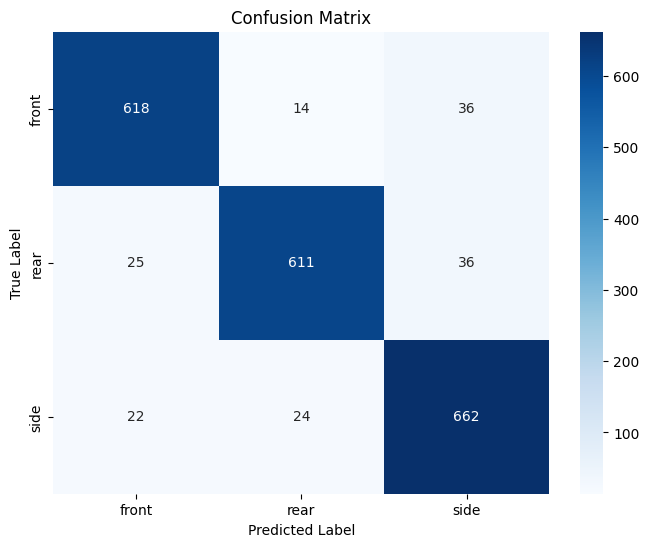

time: 13.7 s (started: 2024-06-20 13:39:51 +00:00)


In [ ]:
## Lists to hold predictions and labels
y_true = []
y_pred = []

# Iterate through the test set batches
for images, labels in test_set_raw:
    yhat_probs = best_model.predict(images)  # Predict directly on the tensor batch
    yhat = tf.argmax(yhat_probs, axis=1)  # Get predicted class indices

    y_true.extend(labels)     # Convert TensorFlow tensor to NumPy for compatibility
    y_pred.extend(yhat)        # Convert TensorFlow tensor to NumPy for compatibility
    # y_true.extend(labels.numpy())     # Convert TensorFlow tensor to NumPy for compatibility
    # y_pred.extend(yhat.numpy())        # Convert TensorFlow tensor to NumPy for compatibility


# Ensure all classes are represented in the confusion matrix
# unique_labels = np.unique(y_true + y_pred)
cm = confusion_matrix(y_true, y_pred, labels=range(len(class_names)))

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix') ## EfficientNet
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Confusion Matrix
conf_mat = confusion_matrix(y_true, y_pred)

# Classification Report (includes precision, recall, F1-score)
report = classification_report(y_true, y_pred, target_names=class_names)

print(report)


              precision    recall  f1-score   support

       front       0.93      0.93      0.93       668
        rear       0.94      0.91      0.93       672
        side       0.90      0.94      0.92       708

    accuracy                           0.92      2048
   macro avg       0.92      0.92      0.92      2048
weighted avg       0.92      0.92      0.92      2048

time: 83.9 ms (started: 2024-06-20 13:41:41 +00:00)


In [ ]:
conf_mat ## efficientNet

array([[618,  14,  36],
       [ 25, 611,  36],
       [ 22,  24, 662]])

time: 2.67 ms (started: 2024-06-20 13:43:14 +00:00)


In [ ]:
class_names_list = list(class_names)
class_names_list

['front', 'rear', 'side']

time: 4.95 ms (started: 2024-06-20 13:44:35 +00:00)


### **Fine Tune by unfreezing top layers of the model**
The headless EfficientNetV2B0 contains 271 layers. The fine tuning process is set to start @ 200th layer

In [ ]:
base_model.trainable = True

# Freeze all the layers before the `fine_tune_at` layer
fine_tune_at = 200
for layer in base_model.layers[:fine_tune_at]:
   layer.trainable = False

time: 14.9 ms (started: 2024-06-18 08:52:13 +00:00)


#### **Recompile Model**
Lower learning rate is used to avoid quick overfitting.

In [ ]:
optim = tfa.optimizers.AdaBelief(learning_rate=1e-8/10,
                                 weight_decay=TL_WEIGHT_DECAY,
                                 epsilon=TL_EPSILON)

model.compile(optimizer=optim,
             loss="sparse_categorical_crossentropy",
             metrics=['acc'])

time: 12.7 ms (started: 2024-06-18 08:52:18 +00:00)


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 efficientnetv2-b0 (Functio  (None, 1280)              5919312   
 nal)                                                            
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 3)                 3843      
                                                                 
Total params: 5923155 (22.60 MB)
Trainable params: 2863603 (10.92 MB)
Non-trainable params: 3059552 (11.67 MB)
________________

In [ ]:
# Initialize a new wandb run
run = wandb.init(project="experiment_tuning_panel",
                # id='ojqvhab6',
                     save_code = True)

epoch/acc,▂▄▄▃▁█▂▄▂▁▃
epoch/epoch,▁▂▂▃▄▅▅▆▇▇█
epoch/learning_rate,██████▂▂▁▁▁
epoch/loss,▅▄▃█▅▁▆▄█▇▅
epoch/val_acc,▆▄▃▆▂█▁▆▂▁▃
epoch/val_loss,▅▂▅▁▇▃█▃▇▇▅
epoch/acc,0.88383
epoch/epoch,127
epoch/learning_rate,0.0
epoch/loss,0.31619
epoch/val_acc,0.88104


time: 11.1 s (started: 2024-06-18 08:46:25 +00:00)


In [ ]:
# Initialize with project and entity
# wandb.init(project="experiment_tuning_panel", entity="cpedrosa")

# Get the run
api = wandb.Api()
run = api.run("cpedrosa/experiment_tuning_panel/h6yrqs6x")
history = run.history()

# Find the row with the minimum validation loss
best_epoch_index = history["epoch/val_loss"].idxmin()

# Get the best validation loss value
best_val_loss = history.loc[best_epoch_index, "epoch/val_loss"]

# Find the model artifact for the best epoch
artifact = api.artifact(f"cpedrosa/experiment_tuning_panel/run_5jdjgkch_model:v{best_epoch_index}")
artifact_dir = artifact.download()

# Load the model
best_model = load_model(artifact_dir)

time: 620 ms (started: 2024-06-18 11:15:29 +00:00)


In [ ]:
print(best_epoch_index)
print(best_val_loss)

0
0.41972920298576355
time: 856 µs (started: 2024-06-18 11:10:55 +00:00)


In [ ]:
test_loss, test_acc = best_model.evaluate(test_set_raw)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

65/65 [==============================] - 10s 38ms/step - loss: 0.2951 - acc: 0.8878
Test Loss: 0.2950645089149475
Test Accuracy: 0.8878143429756165
time: 9.54 s (started: 2024-06-18 09:19:05 +00:00)


In [ ]:
num_test_images = 0
for images, labels in test_set_raw:
    num_test_images += len(labels)
print(f"Number of test images: {num_test_images}")

Number of test images: 1034
time: 7.64 s (started: 2024-06-18 12:12:01 +00:00)


1/1 [==============================] - 0s 29ms/step


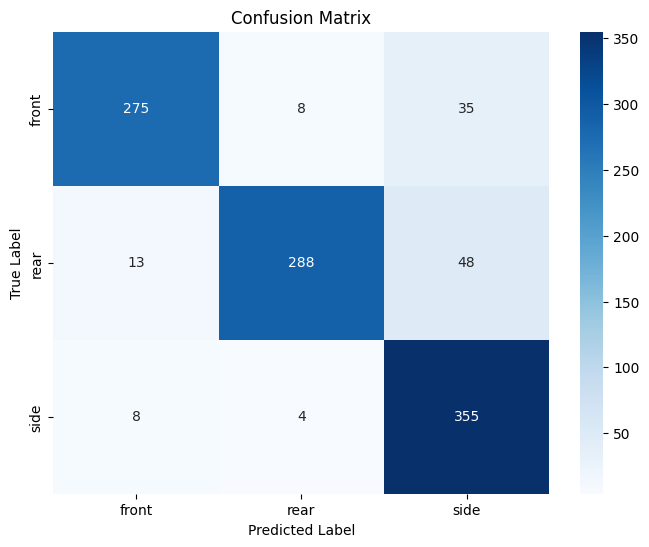

time: 11.3 s (started: 2024-06-18 12:03:23 +00:00)


In [ ]:
# Lists to hold predictions and labels
y_true = []
y_pred = []

# Iterate through the test set batches
for images, labels in test_set_raw:
    yhat_probs = best_model.predict(images)  # Predict directly on the tensor batch
    yhat = tf.argmax(yhat_probs, axis=1)  # Get predicted class indices

    y_true.extend(labels.numpy())     # Convert TensorFlow tensor to NumPy for compatibility
    y_pred.extend(yhat.numpy())        # Convert TensorFlow tensor to NumPy for compatibility


# Ensure all classes are represented in the confusion matrix
unique_labels = np.unique(y_true + y_pred)
cm = confusion_matrix(y_true, y_pred, labels=range(len(class_names)))

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()